# Sequential Workflow Analysis for General Split Data

This notebook demonstrates the complete sequential fraud detection workflow using models trained on general split data (random train/validation/test split). The workflow combines:

1. **Anomaly Detection**: Isolation Forest to identify potential fraud cases
2. **Classification**: Various AutoML models (AutoGluon, FLAML, H2O, XGBoost, CatBoost) to classify flagged anomalies

Unlike the timebased split approach, the general split uses random sampling which allows for better representation of patterns across different time periods but may not reflect real-world temporal deployment scenarios.

# Prerequisites

## Install Libraries

In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import joblib
import json
import os
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns

# AutoML libraries
import flaml
from autogluon.tabular import TabularPredictor
import h2o
from h2o.automl import H2OAutoML

2025-08-11 19:36:36,066	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-08-11 19:36:36,358	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-08-11 19:36:36,358	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Load Test Data

In [3]:
# Load test dataset with fraud cases
df_path = "/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/data/fraudTest_cleaned.csv"
df_test = pd.read_csv(df_path, index_col=0)
sample_df = df_test.copy()

print(f"Loaded test dataset: {sample_df.shape}")

Loaded test dataset: (555719, 48)


## Prep Data

In [4]:
# Create feature sets for different models
# For Isolation Forest and most models: remove personal identifiers and target
X_sample = sample_df.drop(['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'is_fraud'], axis=1)

# For AutoGluon: keep all features except target (AutoGluon expects the same features it was trained on)
X_sample_autogluon = sample_df.drop(['is_fraud'], axis=1)

# Create y_true for evaluation
y_true = sample_df['is_fraud'].values

print(f"X_sample shape (for most models): {X_sample.shape}")
print(f"X_sample_autogluon shape (for AutoGluon): {X_sample_autogluon.shape}")
print(f"y_true shape: {y_true.shape}")

X_sample shape (for most models): (555719, 41)
X_sample_autogluon shape (for AutoGluon): (555719, 47)
y_true shape: (555719,)


# Load Model

## Detection Model

### Isolation Forest Model Evaluation

Evaluate the anomaly detection performance of Isolation Forest as a standalone fraud detection model.

In [5]:
# Isolation Forest Model - General Split Version
iso_model = joblib.load("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/AnomalyDetection/general_split/full_pipeline_isolation_forest_general_split.joblib")

In [6]:
iso_pred = iso_model.predict(X_sample)
predicted_result = (iso_pred == -1).astype(int) # 1 = fraud, 0 = normal

In [7]:
# Evaluate Isolation Forest as Anomaly Detection Model
print("=== ISOLATION FOREST ANOMALY DETECTION EVALUATION ===")
print()

# Get actual fraud labels for comparison
y_true_iso = sample_df['is_fraud'].values

# Convert Isolation Forest predictions to fraud detection format
# iso_pred: -1 = anomaly (fraud), 1 = normal
iso_fraud_pred = (iso_pred == -1).astype(int)  # Convert to 1=fraud, 0=normal

# Calculate anomaly scores for probability-like values
anomaly_scores = iso_model.decision_function(X_sample)
# Normalize anomaly scores to 0-1 range (lower scores = more anomalous)
normalized_scores = (anomaly_scores.max() - anomaly_scores) / (anomaly_scores.max() - anomaly_scores.min())

print(f"Dataset Size: {len(y_true_iso):,} samples")
print(f"Actual Fraud Cases: {sum(y_true_iso):,} ({sum(y_true_iso)/len(y_true_iso)*100:.2f}%)")
print(f"Predicted Anomalies: {sum(iso_fraud_pred):,} ({sum(iso_fraud_pred)/len(iso_fraud_pred)*100:.2f}%)")
print()

# Calculate performance metrics
iso_accuracy = accuracy_score(y_true_iso, iso_fraud_pred)
iso_precision = precision_score(y_true_iso, iso_fraud_pred, zero_division=0)
iso_recall = recall_score(y_true_iso, iso_fraud_pred, zero_division=0)
iso_f1 = f1_score(y_true_iso, iso_fraud_pred, zero_division=0)

# ROC-AUC and PR-AUC using normalized anomaly scores
try:
    iso_roc_auc = roc_auc_score(y_true_iso, normalized_scores)
except:
    iso_roc_auc = roc_auc_score(y_true_iso, iso_fraud_pred)

try:
    iso_pr_auc = average_precision_score(y_true_iso, normalized_scores)
except:
    iso_pr_auc = average_precision_score(y_true_iso, iso_fraud_pred)

# Cohen's Kappa
iso_kappa = cohen_kappa_score(y_true_iso, iso_fraud_pred)

# Confusion Matrix
tn_iso, fp_iso, fn_iso, tp_iso = confusion_matrix(y_true_iso, iso_fraud_pred).ravel()

print("Performance Metrics:")
print(f"  Accuracy:      {iso_accuracy:.4f}")
print(f"  Precision:     {iso_precision:.4f}")
print(f"  Recall:        {iso_recall:.4f}")
print(f"  F1-Score:      {iso_f1:.4f}")
print(f"  ROC-AUC:       {iso_roc_auc:.4f}")
print(f"  PR-AUC:        {iso_pr_auc:.4f}")
print(f"  Cohen's Kappa: {iso_kappa:.4f}")
print()

print("Confusion Matrix:")
print(f"  True Positives:  {tp_iso:,} (Fraud correctly identified)")
print(f"  False Positives: {fp_iso:,} (Normal incorrectly flagged as fraud)")
print(f"  True Negatives:  {tn_iso:,} (Normal correctly identified)")
print(f"  False Negatives: {fn_iso:,} (Fraud missed)")
print()

print("Classification Report:")
print(classification_report(y_true_iso, iso_fraud_pred, target_names=['Normal', 'Fraud']))
print()

# Store Isolation Forest metrics for comparison
isolation_forest_metrics = {
    'model_name': 'Isolation Forest',
    'accuracy': iso_accuracy,
    'precision': iso_precision,
    'recall': iso_recall,
    'f1_score': iso_f1,
    'roc_auc': iso_roc_auc,
    'pr_auc': iso_pr_auc,
    'kappa': iso_kappa,
    'predictions': iso_fraud_pred,
    'probabilities': normalized_scores,
    'confusion_matrix': {'tn': tn_iso, 'fp': fp_iso, 'fn': fn_iso, 'tp': tp_iso},
    'fraud_predictions': sum(iso_fraud_pred),
    'fraud_rate': sum(iso_fraud_pred)/len(iso_fraud_pred)*100
}

print("Isolation Forest evaluation completed!")
print("=" * 60)

=== ISOLATION FOREST ANOMALY DETECTION EVALUATION ===

Dataset Size: 555,719 samples
Actual Fraud Cases: 2,145 (0.39%)
Predicted Anomalies: 7,513 (1.35%)

Dataset Size: 555,719 samples
Actual Fraud Cases: 2,145 (0.39%)
Predicted Anomalies: 7,513 (1.35%)

Performance Metrics:
  Accuracy:      0.9848
  Precision:     0.0809
  Recall:        0.2834
  F1-Score:      0.1259
  ROC-AUC:       0.8479
  PR-AUC:        0.0482
  Cohen's Kappa: 0.1206

Confusion Matrix:
  True Positives:  608 (Fraud correctly identified)
  False Positives: 6,905 (Normal incorrectly flagged as fraud)
  True Negatives:  546,669 (Normal correctly identified)
  False Negatives: 1,537 (Fraud missed)

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99    553574
       Fraud       0.08      0.28      0.13      2145

    accuracy                           0.98    555719
   macro avg       0.54      0.64      0.56    555719
weighted avg       0.99      

In [8]:
# # Calculate fraud probability (normalize anomaly score to 0-1)
# anomaly_score = iso_model.decision_function(X_sample)
# fraud_probability = (anomaly_score.max() - anomaly_score) / (anomaly_score.max() - anomaly_score.min())

# # Add predictions and fraud probability
# sample_df['predicted_result'] = predicted_result
# sample_df['fraud_probability'] = fraud_probability

# # Select columns to display
# columns_to_show = [
#     'trans_date_trans_time', 'trans_num', 'cc_num',  'first', 'last', 'merchant', 'amt',
#     'is_fraud', 'predicted_result', 'fraud_probability'
# ]
# display(sample_df[columns_to_show].reset_index(drop=True))

## Classification Model

### AutoML Model

#### AutoGluon

In [9]:
autogluon_model = TabularPredictor.load("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/general_split/autogluon_output")

In [10]:
preds = autogluon_model.predict_proba(sample_df)
sample_df['predicted_result'] = autogluon_model.predict(sample_df).values.astype(int)
sample_df['fraud_probability'] = preds[1].values

In [11]:
# # Add predictions and fraud probability to sample_df
# sample_df['predicted_result'] = autogluon_model.predict(sample_df).values.astype(int)
# sample_df['fraud_probability'] = preds[1].values

# # Select columns to display
# columns_to_show = [
#     'trans_date_trans_time', 'trans_num', 'cc_num',  'first', 'last', 'merchant', 'amt',
#     'is_fraud', 'predicted_result', 'fraud_probability'
# ]
# display(sample_df[columns_to_show].reset_index(drop=True))

# flaml_model_dir = "/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/general_split/flaml_model/"
# automl_loaded = joblib.load(flaml_model_dir + "flaml_general_split.joblib")

#### FLAML

In [12]:
model_dir = "/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/general_split/flaml_model/"

# Load FLAML model directly
automl_loaded = joblib.load(os.path.join(model_dir, "flaml_fraud_model.joblib"))

# Load label encoders
with open(os.path.join(model_dir, "label_encoders.joblib"), "rb") as f:
    le_dict_loaded = joblib.load(f)

# Load feature names
with open(os.path.join(model_dir, "feature_names.joblib"), "rb") as f:
    expected_features = joblib.load(f)

print("FLAML model loaded successfully!")
print(f"Model type: {type(automl_loaded)}")
print(f"Number of label encoders: {len(le_dict_loaded)}")
print(f"Number of expected features: {len(expected_features)}")
print(f"Label encoder columns: {list(le_dict_loaded.keys())}")

model_loaded = True

FLAML model loaded successfully!
Model type: <class 'flaml.automl.automl.AutoML'>
Number of label encoders: 5
Number of expected features: 47
Label encoder columns: ['first', 'last', 'street', 'dob', 'trans_num']


In [13]:
# # Display results
# columns_to_show = [
#     'trans_date_trans_time', 'trans_num', 'cc_num', 'first', 'last', 'merchant', 'amt',
#     'is_fraud', 'predicted_result', 'fraud_probability'
# ]

# available_columns = [col for col in columns_to_show if col in sample_df.columns]
# print(f"Available columns: {available_columns}")

# if len(available_columns) > 0:
#     display(sample_df[available_columns].reset_index(drop=True))
# else:
#     display(sample_df.head())

#### H2O

In [14]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html
 connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,8 days 22 hours 18 mins
H2O_cluster_timezone:,Asia/Bangkok
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 15 days
H2O_cluster_name:,H2O_from_python_thanyalak_zmdigb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.898 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [15]:
X_sample_h2o = h2o.H2OFrame(X_sample)
print(f"Sample data shape: {X_sample.shape}")

Parse progress: |██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| (done) 100%
██████████| (done) 100%
Sample data shape: (555719, 41)
Sample data shape: (555719, 41)


In [16]:
h2o_model = h2o.load_model("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/general_split/h2o_leader_model/StackedEnsemble_H2OAutoML_GeneralSplit")

In [17]:
preds = h2o_model.predict(X_sample_h2o).as_data_frame()

stackedensemble prediction progress: |█████████████████████████████████████████████| (done) 100%
█████████████████████████████████████████| (done) 100%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [18]:
# # Add predictions and fraud probability to sample_df
# sample_df['predicted_result'] = preds['predict'].values.astype(int)  # 1 = fraud, 0 = normal
# sample_df['fraud_probability'] = preds['p1'].values

# # Select columns to display
# columns_to_show = [
#     'trans_date_trans_time', 'trans_num', 'cc_num',  'first', 'last', 'merchant', 'amt',
#     'is_fraud', 'predicted_result', 'fraud_probability'
# ]
# display(sample_df[columns_to_show].reset_index(drop=True))

### Manual Classification Model

#### XGBoost with SMOTETomek Resampling Technique

In [19]:
xgboost_model = joblib.load("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/general_split/xgboost_general_split_SMOTETomek/xgboost_smotetomek_general_split_model.joblib")

In [20]:
xgb_pred = xgboost_model.predict(X_sample)
predicted_result = xgb_pred

In [21]:
# # Calculate fraud probability
# fraud_probability = xgboost_model.predict_proba(X_sample)[:, 1]

# # Add predictions and fraud probability to sample_df
# sample_df['predicted_result'] = predicted_result
# sample_df['fraud_probability'] = fraud_probability

# # Select columns to display
# columns_to_show = [
#     'trans_date_trans_time', 'trans_num', 'cc_num',  'first', 'last', 'merchant', 'amt',
#     'is_fraud', 'predicted_result', 'fraud_probability'
# ]
# display(sample_df[columns_to_show].reset_index(drop=True))

#### CatBoost

In [22]:
catboost_model = joblib.load("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/general_split/catboost_general_split_high_recall/catboost_general_split.joblib")

In [23]:
cb_pred = catboost_model.predict(X_sample)
predicted_result = cb_pred  # CatBoost returns 0/1 directly

In [24]:
# # Calculate fraud probability
# fraud_probability = catboost_model.predict_proba(X_sample)[:, 1]

# # Add predictions and fraud probability to sample_df
# sample_df['predicted_result'] = predicted_result
# sample_df['fraud_probability'] = fraud_probability

# # Select columns to display
# columns_to_show = [
#     'trans_date_trans_time', 'trans_num', 'cc_num',  'first', 'last', 'merchant', 'amt',
#     'is_fraud', 'predicted_result', 'fraud_probability'
# ]
# display(sample_df[columns_to_show].reset_index(drop=True))

# Individual Model Evaluation

Before implementing the sequential workflow, let's evaluate each classification model individually on the full test dataset to understand their standalone performance.

In [ ]:
def evaluate_individual_model(model, model_name, X_test, y_true, sample_data=None, feature_preparation_func=None):
    """
    Evaluate individual model performance with comprehensive metrics
    
    Args:
        model: The trained model to evaluate
        model_name: Name of the model for display purposes
        X_test: Test features
        y_true: True labels
        sample_data: Original sample data (for models requiring full dataframe)
        feature_preparation_func: Function to prepare features for specific models
    
    Returns:
        Dictionary containing all evaluation metrics
    """

    print(f"=== {model_name.upper()} INDIVIDUAL MODEL EVALUATION ===")
    print()

    try:
        # Prepare data if needed
        if feature_preparation_func:
            X_prepared = feature_preparation_func(X_test if sample_data is None else sample_data)
        else:
            X_prepared = X_test

        # Make predictions
        if hasattr(model, 'predict'):
            predictions = model.predict(X_prepared)

            # Handle H2O model predictions
            if hasattr(predictions, 'as_data_frame'):
                pred_df = predictions.as_data_frame()
                predictions = pred_df['predict'].values
                probabilities = pred_df['p1'].values if 'p1' in pred_df.columns else predictions
            else:
                predictions = predictions.values if hasattr(predictions, 'values') else predictions

                # Get probabilities - Special handling for AutoGluon
                if hasattr(model, 'predict_proba'):
                    proba = model.predict_proba(X_prepared)

                    # Handle different probability output formats
                    if hasattr(proba, 'as_data_frame'):
                        # H2O format
                        probabilities = proba.as_data_frame()['p1'].values
                    elif isinstance(proba, dict) and 1 in proba:
                        # Dictionary format
                        probabilities = proba[1].values
                    elif hasattr(proba, 'values'):
                        # Pandas DataFrame - AutoGluon case
                        proba_array = proba.values
                        if proba_array.ndim > 1 and proba_array.shape[1] > 1:
                            probabilities = proba_array[:, 1]  # Get positive class probabilities
                        else:
                            probabilities = proba_array.flatten()
                    elif hasattr(proba, 'iloc'):
                        # Pandas DataFrame using iloc - Alternative for AutoGluon
                        if proba.shape[1] > 1:
                            probabilities = proba.iloc[:, 1].values  # Get positive class
                        else:
                            probabilities = proba.iloc[:, 0].values
                    elif isinstance(proba, (list, tuple)) and len(proba) > 0:
                        # List/tuple format
                        if hasattr(proba[0], '__len__') and len(proba[0]) > 1:
                            probabilities = [p[1] for p in proba]
                        else:
                            probabilities = proba
                    elif hasattr(proba, 'shape'):
                        # Numpy array or similar
                        if proba.ndim > 1 and proba.shape[1] > 1:
                            probabilities = proba[:, 1]
                        else:
                            probabilities = proba.flatten()
                    else:
                        # Fallback: try to convert to array
                        import numpy as np
                        proba_array = np.array(proba)
                        if proba_array.ndim > 1 and proba_array.shape[1] > 1:
                            probabilities = proba_array[:, 1]
                        else:
                            probabilities = proba_array.flatten()
                else:
                    # No predict_proba method available
                    probabilities = predictions
        else:
            raise ValueError(f"Model {model_name} does not have predict method")

        # Ensure predictions and probabilities are numpy arrays
        import numpy as np
        predictions = np.array(predictions).flatten()
        probabilities = np.array(probabilities).flatten()

        # Debug information for AutoGluon
        if 'autogluon' in model_name.lower():
            print(f"Debug - Predictions shape: {predictions.shape}")
            print(f"Debug - Probabilities shape: {probabilities.shape}")
            print(f"Debug - Predictions type: {type(predictions)}")
            print(f"Debug - Probabilities type: {type(probabilities)}")
            print(f"Debug - Sample predictions: {predictions[:5]}")
            print(f"Debug - Sample probabilities: {probabilities[:5]}")
            print()

        # Calculate metrics
        accuracy = accuracy_score(y_true, predictions)
        precision = precision_score(y_true, predictions, zero_division=0)
        recall = recall_score(y_true, predictions, zero_division=0)
        f1 = f1_score(y_true, predictions, zero_division=0)

        # ROC-AUC and PR-AUC
        try:
            roc_auc = roc_auc_score(y_true, probabilities)
        except Exception as e:
            print(f"Warning: Could not calculate ROC-AUC with probabilities, using predictions instead. Error: {e}")
            try:
                roc_auc = roc_auc_score(y_true, predictions)
            except:
                roc_auc = 0.5  # Default value

        try:
            pr_auc = average_precision_score(y_true, probabilities)
        except Exception as e:
            print(f"Warning: Could not calculate PR-AUC with probabilities, using predictions instead. Error: {e}")
            try:
                pr_auc = average_precision_score(y_true, predictions)
            except:
                pr_auc = sum(y_true) / len(y_true)  # Default to class ratio

        # Cohen's Kappa
        kappa = cohen_kappa_score(y_true, predictions)

        # Confusion Matrix
        cm = confusion_matrix(y_true, predictions)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # Handle edge cases where only one class is predicted
            tn = fp = fn = tp = 0
            unique_labels = np.unique(np.concatenate([y_true, predictions]))
            if len(unique_labels) == 1:
                if unique_labels[0] == 0:
                    tn = len(y_true)
                else:
                    tp = len(y_true)

        # Display results
        print(f"Dataset Size: {len(y_true):,} samples")
        print(f"Actual Fraud Cases: {sum(y_true):,} ({sum(y_true)/len(y_true)*100:.2f}%)")
        print(f"Predicted Fraud Cases: {sum(predictions):,} ({sum(predictions)/len(predictions)*100:.2f}%)")
        print()

        print("Performance Metrics:")
        print(f"  Accuracy:      {accuracy:.4f}")
        print(f"  Precision:     {precision:.4f}")
        print(f"  Recall:        {recall:.4f}")
        print(f"  F1-Score:      {f1:.4f}")
        print(f"  ROC-AUC:       {roc_auc:.4f}")
        print(f"  PR-AUC:        {pr_auc:.4f}")
        print(f"  Cohen's Kappa: {kappa:.4f}")
        print()

        print("Confusion Matrix:")
        print(f"  True Positives:  {tp:,} (Fraud correctly identified)")
        print(f"  False Positives: {fp:,} (Normal incorrectly flagged as fraud)")
        print(f"  True Negatives:  {tn:,} (Normal correctly identified)")
        print(f"  False Negatives: {fn:,} (Fraud missed)")
        print()

        print("Classification Report:")
        print(classification_report(y_true, predictions, target_names=['Normal', 'Fraud']))
        print()

        # Return metrics dictionary
        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'kappa': kappa,
            'predictions': predictions,
            'probabilities': probabilities,
            'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp},
            'fraud_predictions': sum(predictions),
            'fraud_rate': sum(predictions)/len(predictions)*100
        }

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        import traceback
        traceback.print_exc()
        return None

## AutoGluon Model Evaluation

In [57]:
X_sample_autogluon = sample_df.drop(['is_fraud'], axis=1)

autogluon_metrics = evaluate_individual_model(
    model=autogluon_model,
    model_name="AutoGluon",
    X_test=X_sample_autogluon,
    y_true=y_true,
    sample_data=None,
    feature_preparation_func=None
)

=== AUTOGLUON INDIVIDUAL MODEL EVALUATION ===

Debug - Predictions shape: (555719,)
Debug - Probabilities shape: (555719,)
Debug - Predictions type: <class 'numpy.ndarray'>
Debug - Probabilities type: <class 'numpy.ndarray'>
Debug - Sample predictions: [0 0 0 0 0]
Debug - Sample probabilities: [2.92274982e-10 3.29652030e-05 3.30601679e-09 1.23387007e-08
 2.26103083e-08]

Dataset Size: 555,719 samples
Actual Fraud Cases: 2,145 (0.39%)
Predicted Fraud Cases: 1,213 (0.22%)

Performance Metrics:
  Accuracy:      0.9982
  Precision:     0.9711
  Recall:        0.5492
  F1-Score:      0.7016
  ROC-AUC:       0.9936
  PR-AUC:        0.8097
  Cohen's Kappa: 0.7008

Confusion Matrix:
  True Positives:  1,178 (Fraud correctly identified)
  False Positives: 35 (Normal incorrectly flagged as fraud)
  True Negatives:  553,539 (Normal correctly identified)
  False Negatives: 967 (Fraud missed)

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00     

## FLAML Model Evaluation

In [58]:
# Function to prepare FLAML data (needed for FLAML evaluation)
def prepare_flaml_data(X_data):
    """Prepare data for FLAML model with proper encoding and feature alignment"""
    X_prepared = X_data.copy()

    # Apply label encoders to categorical features
    for col, le in le_dict_loaded.items():
        if col in X_prepared.columns:
            # Handle unseen categories
            original_values = X_prepared[col].astype(str)
            known_values = set(le.classes_)

            # Replace unseen values with most common class (typically 0)
            X_prepared[col] = original_values.apply(
                lambda x: x if x in known_values else le.classes_[0]
            )

            # Transform using label encoder
            X_prepared[col] = le.transform(X_prepared[col])

    # Ensure feature alignment with expected features
    missing_features = set(expected_features) - set(X_prepared.columns)
    for feature in missing_features:
        X_prepared[feature] = 0

    # Remove extra features and reorder
    X_prepared = X_prepared[expected_features]

    return X_prepared

print("FLAML data preparation function defined!")

FLAML data preparation function defined!


In [59]:
# Evaluate FLAML Model
flaml_metrics = evaluate_individual_model(
    model=automl_loaded,
    model_name="FLAML",
    X_test=X_sample,
    y_true=y_true,
    feature_preparation_func=prepare_flaml_data
)

=== FLAML INDIVIDUAL MODEL EVALUATION ===

Dataset Size: 555,719 samples
Actual Fraud Cases: 2,145 (0.39%)
Predicted Fraud Cases: 1,615 (0.29%)

Performance Metrics:
  Accuracy:      0.9980
  Precision:     0.8155
  Recall:        0.6140
  F1-Score:      0.7005
  ROC-AUC:       0.9880
  PR-AUC:        0.6734
  Cohen's Kappa: 0.6995

Confusion Matrix:
  True Positives:  1,317 (Fraud correctly identified)
  False Positives: 298 (Normal incorrectly flagged as fraud)
  True Negatives:  553,276 (Normal correctly identified)
  False Negatives: 828 (Fraud missed)

Classification Report:
Dataset Size: 555,719 samples
Actual Fraud Cases: 2,145 (0.39%)
Predicted Fraud Cases: 1,615 (0.29%)

Performance Metrics:
  Accuracy:      0.9980
  Precision:     0.8155
  Recall:        0.6140
  F1-Score:      0.7005
  ROC-AUC:       0.9880
  PR-AUC:        0.6734
  Cohen's Kappa: 0.6995

Confusion Matrix:
  True Positives:  1,317 (Fraud correctly identified)
  False Positives: 298 (Normal incorrectly flagge

## H2O Model Evaluation

In [60]:
# H2O model requires H2OFrame
def prepare_h2o_data(X_data):
    return h2o.H2OFrame(X_data)

# Evaluate H2O Model
h2o_metrics = evaluate_individual_model(
    model=h2o_model,
    model_name="H2O AutoML",
    X_test=X_sample,
    y_true=y_true,
    feature_preparation_func=prepare_h2o_data
)

=== H2O AUTOML INDIVIDUAL MODEL EVALUATION ===

Parse progress: |Parse progress: |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| (done) 100%
█████████| (done) 100%
stackedensemble prediction progress: |stackedensemble prediction progress: |█████████████████████████████████████████████| (done) 100%
█████████████████████████████████████████| (done) 100%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Dataset Size: 555,719 samples
Actual Fraud Cases: 2,145 (0.39%)
Predicted Fraud Cases: 1,972 (0.35%)

Performance Metrics:
  Accuracy:      0.9989
  Precision:     0.8905
  Recall:        0.8186
  F1-Score:      0.8530
  ROC-AUC:       0.9964
  PR-AUC:        0.9035
  Cohen's Kappa: 0.8525

Confusion Matrix:
  True Positives:  1,756 (Fraud correctly identified)
  False Positives: 216 (Normal incorrectly flagged as fraud)
  True Negatives:  553,358 (Normal correctly identified)
  False Negatives: 389 (Fraud missed)

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    553574
       Fraud       0.89      0.82      0.85      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.91      0.93    555719
weighted avg       1.00      1.00      1.00    555719


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    553574
       Fraud       

## XGBoost Model Evaluation

In [61]:
# Evaluate XGBoost Model
xgboost_metrics = evaluate_individual_model(
    model=xgboost_model,
    model_name="XGBoost (SMOTETomek)",
    X_test=X_sample,
    y_true=y_true
)

=== XGBOOST (SMOTETOMEK) INDIVIDUAL MODEL EVALUATION ===



Dataset Size: 555,719 samples
Actual Fraud Cases: 2,145 (0.39%)
Predicted Fraud Cases: 4,895 (0.88%)

Performance Metrics:
  Accuracy:      0.9936
  Precision:     0.3555
  Recall:        0.8112
  F1-Score:      0.4943
  ROC-AUC:       0.9859
  PR-AUC:        0.7555
  Cohen's Kappa: 0.4916

Confusion Matrix:
  True Positives:  1,740 (Fraud correctly identified)
  False Positives: 3,155 (Normal incorrectly flagged as fraud)
  True Negatives:  550,419 (Normal correctly identified)
  False Negatives: 405 (Fraud missed)

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00    553574
       Fraud       0.36      0.81      0.49      2145

    accuracy                           0.99    555719
   macro avg       0.68      0.90      0.75    555719
weighted avg       1.00      0.99      0.99    555719


              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00    553574
       Fraud     

## CatBoost Model Evaluation

In [62]:
# Evaluate CatBoost Model
catboost_metrics = evaluate_individual_model(
    model=catboost_model,
    model_name="CatBoost",
    X_test=X_sample,
    y_true=y_true
)

=== CATBOOST INDIVIDUAL MODEL EVALUATION ===

Dataset Size: 555,719 samples
Actual Fraud Cases: 2,145 (0.39%)
Predicted Fraud Cases: 16,525 (2.97%)

Performance Metrics:
  Accuracy:      0.9734
  Precision:     0.1183
  Recall:        0.9114
  F1-Score:      0.2094
  ROC-AUC:       0.9898
  PR-AUC:        0.7273
  Cohen's Kappa: 0.2040

Confusion Matrix:
  True Positives:  1,955 (Fraud correctly identified)
  False Positives: 14,570 (Normal incorrectly flagged as fraud)
  True Negatives:  539,004 (Normal correctly identified)
  False Negatives: 190 (Fraud missed)

Classification Report:
Dataset Size: 555,719 samples
Actual Fraud Cases: 2,145 (0.39%)
Predicted Fraud Cases: 16,525 (2.97%)

Performance Metrics:
  Accuracy:      0.9734
  Precision:     0.1183
  Recall:        0.9114
  F1-Score:      0.2094
  ROC-AUC:       0.9898
  PR-AUC:        0.7273
  Cohen's Kappa: 0.2040

Confusion Matrix:
  True Positives:  1,955 (Fraud correctly identified)
  False Positives: 14,570 (Normal incorre

## Individual Models Comparison Summary

In [63]:
# Collect all individual model metrics
individual_models_metrics = []
for metrics in [isolation_forest_metrics, autogluon_metrics, flaml_metrics, h2o_metrics, xgboost_metrics, catboost_metrics]:
    if metrics is not None:
        individual_models_metrics.append(metrics)

if individual_models_metrics:
    print("=" * 80)
    print("INDIVIDUAL MODELS PERFORMANCE COMPARISON")
    print("=" * 80)
    print(f"{'Model':<20} {'Precision':<10} {'Recall':<8} {'F1-Score':<9} {'ROC-AUC':<9} {'PR-AUC':<8} {'Kappa':<8}")
    print("-" * 80)

    for metrics in individual_models_metrics:
        print(f"{metrics['model_name']:<20} {metrics['precision']:<10.4f} {metrics['recall']:<8.4f} "
              f"{metrics['f1_score']:<9.4f} {metrics['roc_auc']:<9.4f} {metrics['pr_auc']:<8.4f} "
              f"{metrics['kappa']:<8.4f}")

    print("-" * 80)

    # Find best performing models
    best_individual = {}
    metrics_names = ['precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc', 'kappa']

    for metric in metrics_names:
        best_model = max(individual_models_metrics, key=lambda x: x[metric])
        best_individual[metric] = (best_model['model_name'], best_model[metric])

    print("\nBEST INDIVIDUAL MODEL BY METRIC:")
    print("-" * 50)
    for metric, (model_name, score) in best_individual.items():
        print(f"Best {metric.replace('_', '-').title()}: {model_name} ({score:.4f})")

    # Calculate composite scores for individual models
    individual_composite = {}
    for metrics in individual_models_metrics:
        composite = (0.30 * metrics['f1_score'] +
                    0.25 * metrics['roc_auc'] +
                    0.20 * metrics['pr_auc'] +
                    0.15 * metrics['precision'] +
                    0.10 * metrics['recall'])
        individual_composite[metrics['model_name']] = composite

    # Sort by composite score
    sorted_individual = sorted(individual_composite.items(), key=lambda x: x[1], reverse=True)

    print(f"\nINDIVIDUAL MODELS COMPOSITE SCORE RANKING:")
    print("-" * 50)
    for i, (model_name, score) in enumerate(sorted_individual, 1):
        print(f"{i}. {model_name}: {score:.4f}")

    best_individual_overall = sorted_individual[0][0]
    best_individual_score = sorted_individual[0][1]

    print(f"\nBEST INDIVIDUAL MODEL OVERALL: {best_individual_overall}")
    print(f"Composite Score: {best_individual_score:.4f}")
    print()

else:
    print("No individual model metrics available for comparison.")
    print()

INDIVIDUAL MODELS PERFORMANCE COMPARISON
Model                Precision  Recall   F1-Score  ROC-AUC   PR-AUC   Kappa   
--------------------------------------------------------------------------------
Isolation Forest     0.0809     0.2834   0.1259    0.8479    0.0482   0.1206  
AutoGluon            0.9711     0.5492   0.7016    0.9936    0.8097   0.7008  
FLAML                0.8155     0.6140   0.7005    0.9880    0.6734   0.6995  
H2O AutoML           0.8905     0.8186   0.8530    0.9964    0.9035   0.8525  
XGBoost (SMOTETomek) 0.3555     0.8112   0.4943    0.9859    0.7555   0.4916  
CatBoost             0.1183     0.9114   0.2094    0.9898    0.7273   0.2040  
--------------------------------------------------------------------------------

BEST INDIVIDUAL MODEL BY METRIC:
--------------------------------------------------
Best Precision: AutoGluon (0.9711)
Best Recall: CatBoost (0.9114)
Best F1-Score: H2O AutoML (0.8530)
Best Roc-Auc: H2O AutoML (0.9964)
Best Pr-Auc: H2O AutoML 

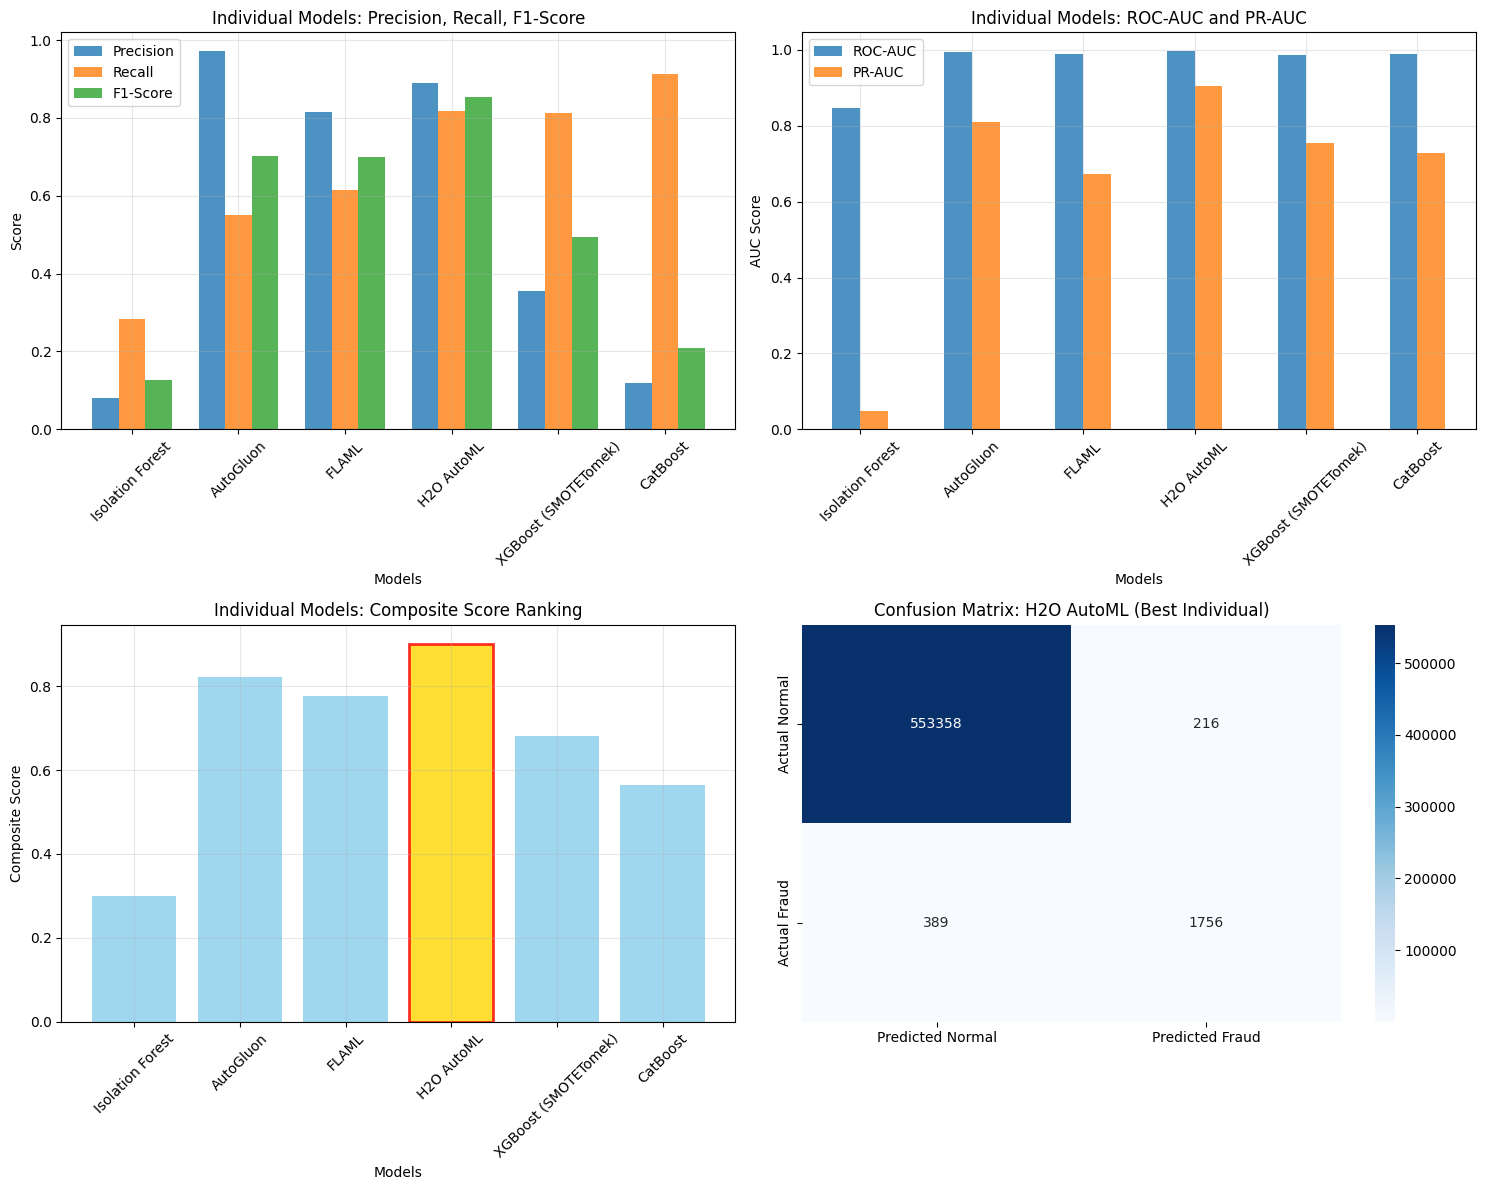


DETAILED INDIVIDUAL MODELS COMPARISON TABLE
               Model Accuracy Precision Recall F1-Score ROC-AUC PR-AUC Cohen_Kappa Fraud_Predictions Fraud_Rate Composite_Score
    Isolation Forest   0.9848    0.0809 0.2834   0.1259  0.8479 0.0482      0.1206             7,513      1.35%          0.2999
           AutoGluon   0.9982    0.9711 0.5492   0.7016  0.9936 0.8097      0.7008             1,213      0.22%          0.8214
               FLAML   0.9980    0.8155 0.6140   0.7005  0.9880 0.6734      0.6995             1,615      0.29%          0.7756
          H2O AutoML   0.9989    0.8905 0.8186   0.8530  0.9964 0.9035      0.8525             1,972      0.35%          0.9012
XGBoost (SMOTETomek)   0.9936    0.3555 0.8112   0.4943  0.9859 0.7555      0.4916             4,895      0.88%          0.6803
            CatBoost   0.9734    0.1183 0.9114   0.2094  0.9898 0.7273      0.2040            16,525      2.97%          0.5646

Best Individual Model: H2O AutoML (Composite Score: 0.9012

In [64]:
# Visualize Individual Models Performance
if individual_models_metrics:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    model_names_individual = [m['model_name'] for m in individual_models_metrics]

    # 1. Precision, Recall, F1-Score Comparison
    precision_vals_ind = [m['precision'] for m in individual_models_metrics]
    recall_vals_ind = [m['recall'] for m in individual_models_metrics]
    f1_vals_ind = [m['f1_score'] for m in individual_models_metrics]

    x = np.arange(len(model_names_individual))
    width = 0.25

    axes[0, 0].bar(x - width, precision_vals_ind, width, label='Precision', alpha=0.8)
    axes[0, 0].bar(x, recall_vals_ind, width, label='Recall', alpha=0.8)
    axes[0, 0].bar(x + width, f1_vals_ind, width, label='F1-Score', alpha=0.8)
    axes[0, 0].set_xlabel('Models')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Individual Models: Precision, Recall, F1-Score')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(model_names_individual, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. ROC-AUC and PR-AUC Comparison
    roc_auc_vals_ind = [m['roc_auc'] for m in individual_models_metrics]
    pr_auc_vals_ind = [m['pr_auc'] for m in individual_models_metrics]

    axes[0, 1].bar(x - width/2, roc_auc_vals_ind, width, label='ROC-AUC', alpha=0.8)
    axes[0, 1].bar(x + width/2, pr_auc_vals_ind, width, label='PR-AUC', alpha=0.8)
    axes[0, 1].set_xlabel('Models')
    axes[0, 1].set_ylabel('AUC Score')
    axes[0, 1].set_title('Individual Models: ROC-AUC and PR-AUC')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(model_names_individual, rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Composite Score Comparison
    composite_vals_ind = [individual_composite[name] for name in model_names_individual]

    bars = axes[1, 0].bar(model_names_individual, composite_vals_ind, color='skyblue', alpha=0.8)
    axes[1, 0].set_xlabel('Models')
    axes[1, 0].set_ylabel('Composite Score')
    axes[1, 0].set_title('Individual Models: Composite Score Ranking')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

    # Highlight best model
    best_idx = model_names_individual.index(best_individual_overall)
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(2)

    # 4. Confusion Matrix Heatmap for Best Model
    best_metrics = individual_models_metrics[best_idx]
    cm = best_metrics['confusion_matrix']
    cm_matrix = np.array([[cm['tn'], cm['fp']], [cm['fn'], cm['tp']]])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal', 'Predicted Fraud'],
                yticklabels=['Actual Normal', 'Actual Fraud'],
                ax=axes[1, 1])
    axes[1, 1].set_title(f'Confusion Matrix: {best_individual_overall} (Best Individual)')

    plt.tight_layout()
    plt.show()

    # Create detailed comparison table
    print("\n" + "=" * 120)
    print("DETAILED INDIVIDUAL MODELS COMPARISON TABLE")
    print("=" * 120)

    comparison_df = pd.DataFrame({
        'Model': [m['model_name'] for m in individual_models_metrics],
        'Accuracy': [f"{accuracy_score(y_true, m['predictions']):.4f}" for m in individual_models_metrics],
        'Precision': [f"{m['precision']:.4f}" for m in individual_models_metrics],
        'Recall': [f"{m['recall']:.4f}" for m in individual_models_metrics],
        'F1-Score': [f"{m['f1_score']:.4f}" for m in individual_models_metrics],
        'ROC-AUC': [f"{m['roc_auc']:.4f}" for m in individual_models_metrics],
        'PR-AUC': [f"{m['pr_auc']:.4f}" for m in individual_models_metrics],
        'Cohen_Kappa': [f"{m['kappa']:.4f}" for m in individual_models_metrics],
        'Fraud_Predictions': [f"{m['fraud_predictions']:,}" for m in individual_models_metrics],
        'Fraud_Rate': [f"{m['fraud_rate']:.2f}%" for m in individual_models_metrics],
        'Composite_Score': [f"{individual_composite[m['model_name']]:.4f}" for m in individual_models_metrics]
    })

    print(comparison_df.to_string(index=False))
    print(f"\nBest Individual Model: {best_individual_overall} (Composite Score: {best_individual_score:.4f})")
    print("=" * 120)

else:
    print("No individual models available for visualization.")

# Sequential Workflow vs Individual Models

## Summary of Individual Model Performance

The above evaluation shows how each classification model performs when applied to the entire test dataset directly. This represents the traditional approach where models classify all transactions without any preprocessing filter.

## Sequential Workflow Approach

The sequential workflow takes a different approach:

1. **Step 1 - Anomaly Detection**: Use Isolation Forest to identify potentially fraudulent transactions (anomalies)
2. **Step 2 - Classification**: Apply classification models only to the anomalous transactions identified in Step 1

This approach can potentially:
- **Reduce computational load** by processing fewer transactions through expensive classification models
- **Improve precision** by focusing classification efforts on already suspicious transactions
- **Reduce false positives** by not flagging clearly normal transactions as fraud

The following sections compare the sequential workflow performance with the individual model performance shown above.

## Individual vs Sequential Performance Analysis

Compare the performance of individual models with the sequential workflow to understand the trade-offs.

In [65]:
# Sequential Workflow Implementation

print("=== SEQUENTIAL FRAUD DETECTION WORKFLOW ===")
print("Step 1: Anomaly Detection (Isolation Forest)")
print("Step 2: Classification on Anomalous Transactions")
print()

# Step 1: Get anomaly predictions from Isolation Forest
iso_pred = iso_model.predict(X_sample)
anomaly_mask = (iso_pred == -1)  # True for anomalous transactions
anomaly_indices = np.where(anomaly_mask)[0]

print(f"Total transactions: {len(X_sample)}")
print(f"Anomalous transactions detected: {len(anomaly_indices)} ({len(anomaly_indices)/len(X_sample)*100:.2f}%)")
print()

# Extract anomalous transactions for classification
X_anomalous = X_sample.iloc[anomaly_indices].copy()
sample_anomalous = sample_df.iloc[anomaly_indices].copy()

print(f"Anomalous transactions to classify: {len(X_anomalous)}")
print()

# Initialize results dictionary
sequential_results = {
    'total_transactions': len(X_sample),
    'anomalous_transactions': len(anomaly_indices),
    'models': {}
}

# Function to align FLAML features
def prepare_flaml_data(X_data):
    """Prepare data for FLAML model with proper encoding and feature alignment"""
    X_prepared = X_data.copy()

    # Apply label encoders to categorical features
    for col, le in le_dict_loaded.items():
        if col in X_prepared.columns:
            # Handle unseen categories
            original_values = X_prepared[col].astype(str)
            known_values = set(le.classes_)

            # Replace unseen values with most common class (typically 0)
            X_prepared[col] = original_values.apply(
                lambda x: x if x in known_values else le.classes_[0]
            )

            # Transform using label encoder
            X_prepared[col] = le.transform(X_prepared[col])

    # Ensure feature alignment with expected features
    missing_features = set(expected_features) - set(X_prepared.columns)
    for feature in missing_features:
        X_prepared[feature] = 0

    # Remove extra features and reorder
    X_prepared = X_prepared[expected_features]

    return X_prepared

# Step 2: Apply Classification Models to Anomalous Transactions
if len(X_anomalous) > 0:
    print("=== CLASSIFICATION RESULTS ON ANOMALOUS TRANSACTIONS ===")
    print()

    # 1. AutoGluon Classification
    print("1. AutoGluon Classification:")
    try:
        autogluon_pred = autogluon_model.predict(sample_anomalous)
        autogluon_proba = autogluon_model.predict_proba(sample_anomalous)
        fraud_count_ag = sum(autogluon_pred == 1)

        sequential_results['models']['autogluon'] = {
            'fraud_predictions': fraud_count_ag,
            'fraud_rate': fraud_count_ag / len(X_anomalous) * 100,
            'predictions': autogluon_pred.values,
            'probabilities': autogluon_proba[1].values
        }

        print(f"   Fraud predictions: {fraud_count_ag}/{len(X_anomalous)} ({fraud_count_ag/len(X_anomalous)*100:.1f}%)")
        print(f"   Status: SUCCESS")
    except Exception as e:
        print(f"   Status: FAILED - {e}")
    print()

    # 2. FLAML Classification
    print("2. FLAML Classification:")
    try:
        X_flaml = prepare_flaml_data(X_anomalous)
        flaml_pred = automl_loaded.predict(X_flaml)
        flaml_proba = automl_loaded.predict_proba(X_flaml)
        fraud_count_flaml = sum(flaml_pred == 1)

        sequential_results['models']['flaml'] = {
            'fraud_predictions': fraud_count_flaml,
            'fraud_rate': fraud_count_flaml / len(X_anomalous) * 100,
            'predictions': flaml_pred,
            'probabilities': flaml_proba[:, 1] if flaml_proba.shape[1] > 1 else flaml_proba.flatten()
        }

        print(f"   Fraud predictions: {fraud_count_flaml}/{len(X_anomalous)} ({fraud_count_flaml/len(X_anomalous)*100:.1f}%)")
        print(f"   Status: SUCCESS")
    except Exception as e:
        print(f"   Status: FAILED - {e}")
    print()

    # 3. H2O Classification
    print("3. H2O Classification:")
    try:
        X_h2o = h2o.H2OFrame(X_anomalous)
        h2o_pred_frame = h2o_model.predict(X_h2o).as_data_frame()
        h2o_pred = h2o_pred_frame['predict'].values
        h2o_proba = h2o_pred_frame['p1'].values
        fraud_count_h2o = sum(h2o_pred == 1)

        sequential_results['models']['h2o'] = {
            'fraud_predictions': fraud_count_h2o,
            'fraud_rate': fraud_count_h2o / len(X_anomalous) * 100,
            'predictions': h2o_pred,
            'probabilities': h2o_proba
        }

        print(f"   Fraud predictions: {fraud_count_h2o}/{len(X_anomalous)} ({fraud_count_h2o/len(X_anomalous)*100:.1f}%)")
        print(f"   Status: SUCCESS")
    except Exception as e:
        print(f"   Status: FAILED - {e}")
    print()

    # 4. XGBoost Classification
    print("4. XGBoost Classification:")
    try:
        xgb_pred = xgboost_model.predict(X_anomalous)
        xgb_proba = xgboost_model.predict_proba(X_anomalous)[:, 1]
        fraud_count_xgb = sum(xgb_pred == 1)

        sequential_results['models']['xgboost'] = {
            'fraud_predictions': fraud_count_xgb,
            'fraud_rate': fraud_count_xgb / len(X_anomalous) * 100,
            'predictions': xgb_pred,
            'probabilities': xgb_proba
        }

        print(f"   Fraud predictions: {fraud_count_xgb}/{len(X_anomalous)} ({fraud_count_xgb/len(X_anomalous)*100:.1f}%)")
        print(f"   Status: SUCCESS")
    except Exception as e:
        print(f"   Status: FAILED - {e}")
    print()

    # 5. CatBoost Classification
    print("5. CatBoost Classification:")
    try:
        cb_pred = catboost_model.predict(X_anomalous)
        cb_proba = catboost_model.predict_proba(X_anomalous)[:, 1]
        fraud_count_cb = sum(cb_pred == 1)

        sequential_results['models']['catboost'] = {
            'fraud_predictions': fraud_count_cb,
            'fraud_rate': fraud_count_cb / len(X_anomalous) * 100,
            'predictions': cb_pred,
            'probabilities': cb_proba
        }

        print(f"   Fraud predictions: {fraud_count_cb}/{len(X_anomalous)} ({fraud_count_cb/len(X_anomalous)*100:.1f}%)")
        print(f"   Status: SUCCESS")
    except Exception as e:
        print(f"   Status: FAILED - {e}")
    print()

else:
    print("No anomalous transactions detected by Isolation Forest!")
    print("Sequential workflow cannot proceed.")

=== SEQUENTIAL FRAUD DETECTION WORKFLOW ===
Step 1: Anomaly Detection (Isolation Forest)
Step 2: Classification on Anomalous Transactions

Total transactions: 555719
Anomalous transactions detected: 7513 (1.35%)

Anomalous transactions to classify: 7513

=== CLASSIFICATION RESULTS ON ANOMALOUS TRANSACTIONS ===

1. AutoGluon Classification:
Total transactions: 555719
Anomalous transactions detected: 7513 (1.35%)

Anomalous transactions to classify: 7513

=== CLASSIFICATION RESULTS ON ANOMALOUS TRANSACTIONS ===

1. AutoGluon Classification:
   Fraud predictions: 387/7513 (5.2%)
   Status: SUCCESS

2. FLAML Classification:
   Fraud predictions: 537/7513 (7.1%)
   Status: SUCCESS

3. H2O Classification:
   Fraud predictions: 387/7513 (5.2%)
   Status: SUCCESS

2. FLAML Classification:
   Fraud predictions: 537/7513 (7.1%)
   Status: SUCCESS

3. H2O Classification:
Parse progress: |Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [66]:
# Create Final Sequential Predictions for Each Model with Enhanced Metrics

print("=== SEQUENTIAL WORKFLOW FINAL PREDICTIONS ===")
print()

# Initialize final predictions for all transactions
final_predictions = {}
final_probabilities = {}

# For each model, create full prediction array
for model_name, model_results in sequential_results['models'].items():
    # Initialize with all zeros (normal transactions)
    full_pred = np.zeros(len(X_sample), dtype=int)
    full_proba = np.zeros(len(X_sample), dtype=float)

    # Set predictions for anomalous transactions
    full_pred[anomaly_indices] = model_results['predictions']
    full_proba[anomaly_indices] = model_results['probabilities']

    final_predictions[model_name] = full_pred
    final_probabilities[model_name] = full_proba

# Compare with actual fraud labels
actual_fraud = sample_df['is_fraud'].values
total_actual_fraud = sum(actual_fraud)

print(f"Ground Truth: {total_actual_fraud}/{len(actual_fraud)} actual fraud cases ({total_actual_fraud/len(actual_fraud)*100:.2f}%)")
print()

print("Sequential Workflow Results - Complete Metrics:")
print("=" * 100)
print(f"{'Model':<12} {'Fraud':<6} {'Rate':<6} {'Precision':<10} {'Recall':<8} {'F1-Score':<9} {'ROC-AUC':<9} {'PR-AUC':<8} {'Kappa':<8}")
print("=" * 100)

# Calculate comprehensive metrics for each model
model_metrics = {}
for model_name in final_predictions.keys():
    pred = final_predictions[model_name]
    proba = final_probabilities[model_name]
    fraud_pred = sum(pred)
    fraud_rate = fraud_pred / len(pred) * 100

    # Calculate performance metrics
    precision = precision_score(actual_fraud, pred, zero_division=0)
    recall = recall_score(actual_fraud, pred, zero_division=0)
    f1 = f1_score(actual_fraud, pred, zero_division=0)

    # ROC-AUC (requires probabilities)
    try:
        if np.sum(proba) > 0:  # Check if probabilities are available
            roc_auc = roc_auc_score(actual_fraud, proba)
        else:
            roc_auc = roc_auc_score(actual_fraud, pred)
    except:
        roc_auc = 0.0

    # PR-AUC (Precision-Recall AUC)
    try:
        if np.sum(proba) > 0:
            pr_auc = average_precision_score(actual_fraud, proba)
        else:
            pr_auc = average_precision_score(actual_fraud, pred)
    except:
        pr_auc = 0.0

    # Cohen's Kappa
    try:
        kappa = cohen_kappa_score(actual_fraud, pred)
    except:
        kappa = 0.0

    # Store metrics
    model_metrics[model_name] = {
        'fraud_predictions': fraud_pred,
        'fraud_rate': fraud_rate,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'kappa': kappa
    }

    print(f"{model_name:<12} {fraud_pred:<6} {fraud_rate:<6.1f} {precision:<10.3f} {recall:<8.3f} {f1:<9.3f} {roc_auc:<9.3f} {pr_auc:<8.3f} {kappa:<8.3f}")

print("=" * 100)
print()

# Show detailed comparison with enhanced metrics
print("=== DETAILED SEQUENTIAL WORKFLOW ANALYSIS ===")
print()

for model_name in final_predictions.keys():
    pred = final_predictions[model_name]
    proba = final_probabilities[model_name]
    metrics = model_metrics[model_name]

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(actual_fraud, pred).ravel()

    print(f"{model_name.upper()} Sequential Results:")
    print(f"  Confusion Matrix:")
    print(f"    True Positives (Fraud correctly identified): {tp}")
    print(f"    False Positives (Normal marked as fraud): {fp}")
    print(f"    True Negatives (Normal correctly identified): {tn}")
    print(f"    False Negatives (Fraud missed): {fn}")
    print(f"  Performance Metrics:")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    Recall: {metrics['recall']:.4f}")
    print(f"    F1-Score: {metrics['f1_score']:.4f}")
    print(f"    ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"    PR-AUC: {metrics['pr_auc']:.4f}")
    print(f"    Cohen's Kappa: {metrics['kappa']:.4f}")
    print()

# Find best performing models for each metric
best_models = {}
for metric in ['f1_score', 'precision', 'recall', 'roc_auc', 'pr_auc', 'kappa']:
    best_model = max(model_metrics.keys(), key=lambda x: model_metrics[x][metric])
    best_score = model_metrics[best_model][metric]
    best_models[metric] = (best_model, best_score)

print("BEST PERFORMING MODELS BY METRIC:")
print("-" * 50)
print(f"Best F1-Score: {best_models['f1_score'][0].upper()} ({best_models['f1_score'][1]:.4f})")
print(f"Best Precision: {best_models['precision'][0].upper()} ({best_models['precision'][1]:.4f})")
print(f"Best Recall: {best_models['recall'][0].upper()} ({best_models['recall'][1]:.4f})")
print(f"Best ROC-AUC: {best_models['roc_auc'][0].upper()} ({best_models['roc_auc'][1]:.4f})")
print(f"Best PR-AUC: {best_models['pr_auc'][0].upper()} ({best_models['pr_auc'][1]:.4f})")
print(f"Best Cohen's Kappa: {best_models['kappa'][0].upper()} ({best_models['kappa'][1]:.4f})")

# Calculate composite score with weighted metrics
print(f"\nCOMPOSITE SCORE RANKING:")
print("-" * 50)
composite_scores = {}
for model_name in model_metrics.keys():
    metrics = model_metrics[model_name]
    # Weighted composite score: F1(30%) + ROC-AUC(25%) + PR-AUC(20%) + Precision(15%) + Recall(10%)
    composite = (0.30 * metrics['f1_score'] +
                0.25 * metrics['roc_auc'] +
                0.20 * metrics['pr_auc'] +
                0.15 * metrics['precision'] +
                0.10 * metrics['recall'])
    composite_scores[model_name] = composite

# Sort by composite score
sorted_models = sorted(composite_scores.items(), key=lambda x: x[1], reverse=True)

for i, (model_name, score) in enumerate(sorted_models, 1):
    print(f"{i}. {model_name.upper()}: {score:.4f}")

overall_best = sorted_models[0][0]
overall_best_score = sorted_models[0][1]

print(f"\nOVERALL BEST MODEL: {overall_best.upper()}")
print(f"   Composite Score: {overall_best_score:.4f}")
print(f"   This model provides the best overall performance across all metrics")
print()

print("Sequential Workflow Complete!")

=== SEQUENTIAL WORKFLOW FINAL PREDICTIONS ===

Ground Truth: 2145/555719 actual fraud cases (0.39%)

Sequential Workflow Results - Complete Metrics:
Model        Fraud  Rate   Precision  Recall   F1-Score  ROC-AUC   PR-AUC   Kappa   
autogluon    387    0.1    0.972      0.175    0.297     0.637     0.261    0.296   
autogluon    387    0.1    0.972      0.175    0.297     0.637     0.261    0.296   
flaml        537    0.1    0.736      0.184    0.295     0.637     0.208    0.293   
flaml        537    0.1    0.736      0.184    0.295     0.637     0.208    0.293   
h2o          631    0.1    0.903      0.266    0.411     0.637     0.280    0.410   
h2o          631    0.1    0.903      0.266    0.411     0.637     0.280    0.410   
xgboost      1047   0.2    0.565      0.276    0.371     0.637     0.267    0.369   
xgboost      1047   0.2    0.565      0.276    0.371     0.637     0.267    0.369   
catboost     2750   0.5    0.220      0.283    0.248     0.637     0.246    0.244   



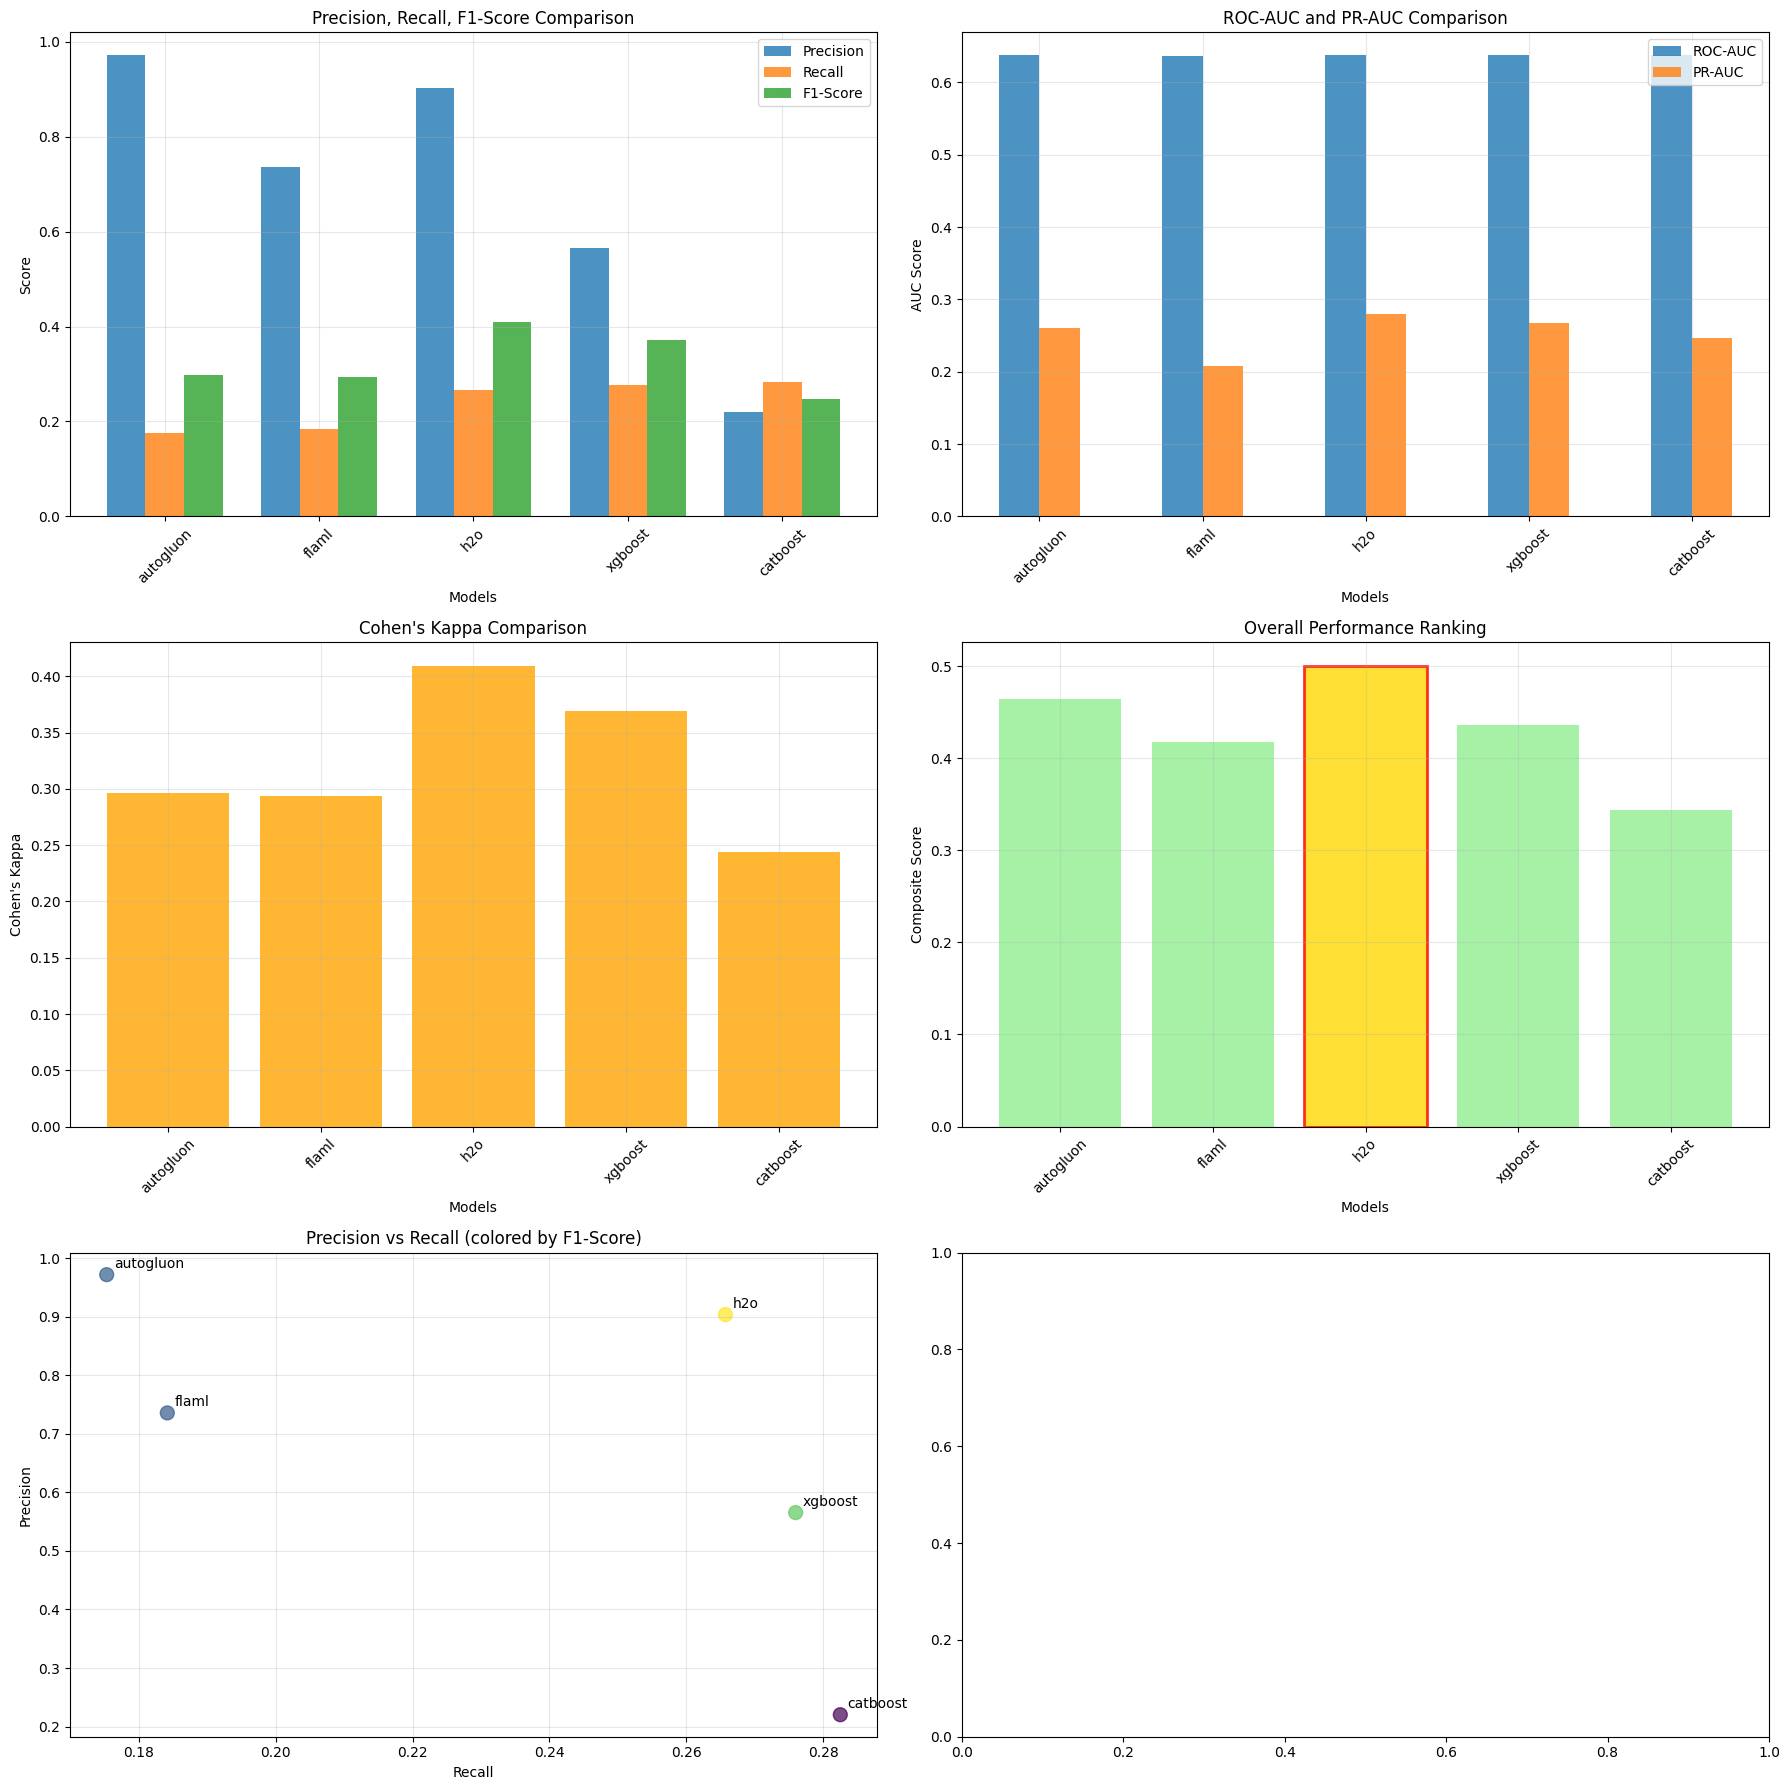

=== COMPREHENSIVE METRICS SUMMARY TABLE ===

    Model Precision Recall F1-Score ROC-AUC PR-AUC Cohen_Kappa Composite_Score
autogluon    0.9716 0.1753   0.2970  0.6372 0.2608      0.2962          0.4638
    flaml    0.7356 0.1841   0.2946  0.6370 0.2080      0.2935          0.4180
      h2o    0.9033 0.2657   0.4107  0.6372 0.2801      0.4096          0.5006
  xgboost    0.5654 0.2760   0.3709  0.6372 0.2668      0.3693          0.4364
 catboost    0.2204 0.2825   0.2476  0.6372 0.2463      0.2443          0.3442

🏆 Overall Winner: H2O with composite score of 0.5006


In [67]:
# Enhanced Visualization with All Metrics

fig, axes = plt.subplots(3, 2, figsize=(18, 18))

model_names = list(final_predictions.keys())

# 1. Precision, Recall, F1-Score Comparison
metrics_names = ['Precision', 'Recall', 'F1-Score']
precision_vals = [model_metrics[model]['precision'] for model in model_names]
recall_vals = [model_metrics[model]['recall'] for model in model_names]
f1_vals = [model_metrics[model]['f1_score'] for model in model_names]

x = np.arange(len(model_names))
width = 0.25

axes[0, 0].bar(x - width, precision_vals, width, label='Precision', alpha=0.8)
axes[0, 0].bar(x, recall_vals, width, label='Recall', alpha=0.8)
axes[0, 0].bar(x + width, f1_vals, width, label='F1-Score', alpha=0.8)
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Precision, Recall, F1-Score Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. ROC-AUC and PR-AUC Comparison
roc_auc_vals = [model_metrics[model]['roc_auc'] for model in model_names]
pr_auc_vals = [model_metrics[model]['pr_auc'] for model in model_names]

axes[0, 1].bar(x - width/2, roc_auc_vals, width, label='ROC-AUC', alpha=0.8)
axes[0, 1].bar(x + width/2, pr_auc_vals, width, label='PR-AUC', alpha=0.8)
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('AUC Score')
axes[0, 1].set_title('ROC-AUC and PR-AUC Comparison')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Cohen's Kappa Comparison
kappa_vals = [model_metrics[model]['kappa'] for model in model_names]

axes[1, 0].bar(model_names, kappa_vals, color='orange', alpha=0.8)
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('Cohen\'s Kappa')
axes[1, 0].set_title('Cohen\'s Kappa Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 4. Composite Score Ranking
composite_vals = [composite_scores[model] for model in model_names]

bars = axes[1, 1].bar(model_names, composite_vals, color='lightgreen', alpha=0.8)
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('Composite Score')
axes[1, 1].set_title('Overall Performance Ranking')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Highlight best model
best_idx = model_names.index(overall_best)
bars[best_idx].set_color('gold')
bars[best_idx].set_edgecolor('red')
bars[best_idx].set_linewidth(2)

# 5. Precision vs Recall Scatter Plot
axes[2, 0].scatter(recall_vals, precision_vals, s=100, alpha=0.7, c=f1_vals, cmap='viridis')
for i, model in enumerate(model_names):
    axes[2, 0].annotate(model, (recall_vals[i], precision_vals[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[2, 0].set_xlabel('Recall')
axes[2, 0].set_ylabel('Precision')
axes[2, 0].set_title('Precision vs Recall (colored by F1-Score)')
axes[2, 0].grid(True, alpha=0.3)

# # 6. All Metrics Radar Chart (normalized)
# from math import pi

# categories = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC', 'Kappa']
# N = len(categories)

# angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]

# axes[2, 1].set_theta_offset(pi / 2)
# axes[2, 1].set_theta_direction(-1)

# for i, model in enumerate(model_names):
#     values = [
#         model_metrics[model]['precision'],
#         model_metrics[model]['recall'],
#         model_metrics[model]['f1_score'],
#         model_metrics[model]['roc_auc'],
#         model_metrics[model]['pr_auc'],
#         model_metrics[model]['kappa']
#     ]
#     values += values[:1]

#     axes[2, 1].plot(angles, values, 'o-', linewidth=2, label=model, alpha=0.8)
#     axes[2, 1].fill(angles, values, alpha=0.1)

# axes[2, 1].set_xticks(angles[:-1])
# axes[2, 1].set_xticklabels(categories)
# axes[2, 1].set_ylim(0, 1)
# axes[2, 1].set_title('All Metrics Comparison (Radar Chart)')
# axes[2, 1].legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
# axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

# Display metrics summary table
print("=== COMPREHENSIVE METRICS SUMMARY TABLE ===")
print()

summary_df = pd.DataFrame({
    'Model': model_names,
    'Precision': [f"{model_metrics[model]['precision']:.4f}" for model in model_names],
    'Recall': [f"{model_metrics[model]['recall']:.4f}" for model in model_names],
    'F1-Score': [f"{model_metrics[model]['f1_score']:.4f}" for model in model_names],
    'ROC-AUC': [f"{model_metrics[model]['roc_auc']:.4f}" for model in model_names],
    'PR-AUC': [f"{model_metrics[model]['pr_auc']:.4f}" for model in model_names],
    'Cohen_Kappa': [f"{model_metrics[model]['kappa']:.4f}" for model in model_names],
    'Composite_Score': [f"{composite_scores[model]:.4f}" for model in model_names]
})

print(summary_df.to_string(index=False))
print()
print(f"🏆 Overall Winner: {overall_best.upper()} with composite score of {overall_best_score:.4f}")

In [68]:
# Compare Individual vs Sequential Performance
print("=" * 120)
print("INDIVIDUAL MODELS vs SEQUENTIAL WORKFLOW PERFORMANCE COMPARISON")
print("=" * 120)

if individual_models_metrics and model_metrics:
    # Create comparison dataframe
    comparison_data = []

    # Individual models performance
    for metrics in individual_models_metrics:
        if metrics['model_name'] != 'Isolation Forest':  # Skip ISO forest as it's used in sequential
            comparison_data.append({
                'Model': f"{metrics['model_name']} (Individual)",
                'Approach': 'Individual',
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1_score'],
                'ROC-AUC': metrics['roc_auc'],
                'PR-AUC': metrics['pr_auc'],
                'Cohen_Kappa': metrics['kappa'],
                'Fraud_Predictions': metrics['fraud_predictions'],
                'Composite_Score': individual_composite.get(metrics['model_name'], 0)
            })

    # Sequential workflow performance
    for model_name in model_metrics.keys():
        comparison_data.append({
            'Model': f"{model_name.title()} (Sequential)",
            'Approach': 'Sequential',
            'Precision': model_metrics[model_name]['precision'],
            'Recall': model_metrics[model_name]['recall'],
            'F1-Score': model_metrics[model_name]['f1_score'],
            'ROC-AUC': model_metrics[model_name]['roc_auc'],
            'PR-AUC': model_metrics[model_name]['pr_auc'],
            'Cohen_Kappa': model_metrics[model_name]['kappa'],
            'Fraud_Predictions': model_metrics[model_name]['fraud_predictions'],
            'Composite_Score': composite_scores.get(model_name, 0)
        })

    # Add Isolation Forest standalone performance
    iso_metrics = next((m for m in individual_models_metrics if m['model_name'] == 'Isolation Forest'), None)
    if iso_metrics:
        iso_composite = (0.30 * iso_metrics['f1_score'] +
                        0.25 * iso_metrics['roc_auc'] +
                        0.20 * iso_metrics['pr_auc'] +
                        0.15 * iso_metrics['precision'] +
                        0.10 * iso_metrics['recall'])
        comparison_data.append({
            'Model': 'Isolation Forest (Standalone)',
            'Approach': 'Anomaly Detection',
            'Precision': iso_metrics['precision'],
            'Recall': iso_metrics['recall'],
            'F1-Score': iso_metrics['f1_score'],
            'ROC-AUC': iso_metrics['roc_auc'],
            'PR-AUC': iso_metrics['pr_auc'],
            'Cohen_Kappa': iso_metrics['kappa'],
            'Fraud_Predictions': iso_metrics['fraud_predictions'],
            'Composite_Score': iso_composite
        })

    # Create and display comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Composite_Score', ascending=False)

    print(f"{'Model':<30} {'Approach':<15} {'Precision':<10} {'Recall':<8} {'F1-Score':<9} {'ROC-AUC':<9} {'PR-AUC':<8} {'Kappa':<8} {'Composite':<10}")
    print("-" * 120)

    for _, row in comparison_df.iterrows():
        print(f"{row['Model']:<30} {row['Approach']:<15} {row['Precision']:<10.4f} {row['Recall']:<8.4f} "
              f"{row['F1-Score']:<9.4f} {row['ROC-AUC']:<9.4f} {row['PR-AUC']:<8.4f} "
              f"{row['Cohen_Kappa']:<8.4f} {row['Composite_Score']:<10.4f}")

    print("-" * 120)

    # Analysis of results
    print("\nKEY INSIGHTS:")
    print("-" * 50)

    # Find best individual vs sequential for each model type
    individual_models = comparison_df[comparison_df['Approach'] == 'Individual']
    sequential_models = comparison_df[comparison_df['Approach'] == 'Sequential']

    if not individual_models.empty and not sequential_models.empty:
        best_individual = individual_models.iloc[0]
        best_sequential = sequential_models.iloc[0]

        print(f"Best Individual Model: {best_individual['Model']} (Composite: {best_individual['Composite_Score']:.4f})")
        print(f"Best Sequential Model: {best_sequential['Model']} (Composite: {best_sequential['Composite_Score']:.4f})")

        if best_sequential['Composite_Score'] > best_individual['Composite_Score']:
            improvement = ((best_sequential['Composite_Score'] - best_individual['Composite_Score']) / best_individual['Composite_Score']) * 100
            print(f"Sequential workflow improves performance by {improvement:.2f}%")
        else:
            decline = ((best_individual['Composite_Score'] - best_sequential['Composite_Score']) / best_individual['Composite_Score']) * 100
            print(f"Individual models outperform sequential workflow by {decline:.2f}%")

    # Computational efficiency analysis
    anomaly_detection_rate = len(anomaly_indices) / len(X_sample) * 100
    print(f"\nCOMPUTATIONAL EFFICIENCY:")
    print(f"- Sequential workflow processes only {anomaly_detection_rate:.2f}% of transactions through classification")
    print(f"- Potential computational savings: {100 - anomaly_detection_rate:.2f}%")
    print(f"- Trade-off: Reduced computational load vs model performance")

    # Isolation Forest analysis
    if iso_metrics:
        print(f"\nISOLATION FOREST ANALYSIS:")
        print(f"- Standalone performance: {iso_composite:.4f} composite score")
        print(f"- Anomaly detection rate: {iso_metrics['fraud_rate']:.2f}%")
        print(f"- Precision: {iso_metrics['precision']:.4f} (minimizes false positives)")
        print(f"- Recall: {iso_metrics['recall']:.4f} (captures true fraud cases)")
        print(f"- Role: Acts as a filter for subsequent classification models")

else:
    print("Insufficient data for comparison analysis.")

print("=" * 120)

INDIVIDUAL MODELS vs SEQUENTIAL WORKFLOW PERFORMANCE COMPARISON
Model                          Approach        Precision  Recall   F1-Score  ROC-AUC   PR-AUC   Kappa    Composite 
------------------------------------------------------------------------------------------------------------------------
H2O AutoML (Individual)        Individual      0.8905     0.8186   0.8530    0.9964    0.9035   0.8525   0.9012    
AutoGluon (Individual)         Individual      0.9711     0.5492   0.7016    0.9936    0.8097   0.7008   0.8214    
FLAML (Individual)             Individual      0.8155     0.6140   0.7005    0.9880    0.6734   0.6995   0.7756    
XGBoost (SMOTETomek) (Individual) Individual      0.3555     0.8112   0.4943    0.9859    0.7555   0.4916   0.6803    
CatBoost (Individual)          Individual      0.1183     0.9114   0.2094    0.9898    0.7273   0.2040   0.5646    
H2O (Sequential)               Sequential      0.9033     0.2657   0.4107    0.6372    0.2801   0.4096   0.5006    


In [69]:
# Ensure sequential_names and sequential metrics are defined
sequential_names = list(model_metrics.keys())
seq_precision = [model_metrics[name]['precision'] for name in sequential_names]
seq_recall = [model_metrics[name]['recall'] for name in sequential_names]
seq_f1 = [model_metrics[name]['f1_score'] for name in sequential_names]

Aligned 5 models for comparison:
  1. Individual: AutoGluon <-> Sequential: AUTOGLUON
  2. Individual: FLAML <-> Sequential: FLAML
  3. Individual: H2O AutoML <-> Sequential: H2O
  4. Individual: XGBoost (SMOTETomek) <-> Sequential: XGBOOST
  5. Individual: CatBoost <-> Sequential: CATBOOST


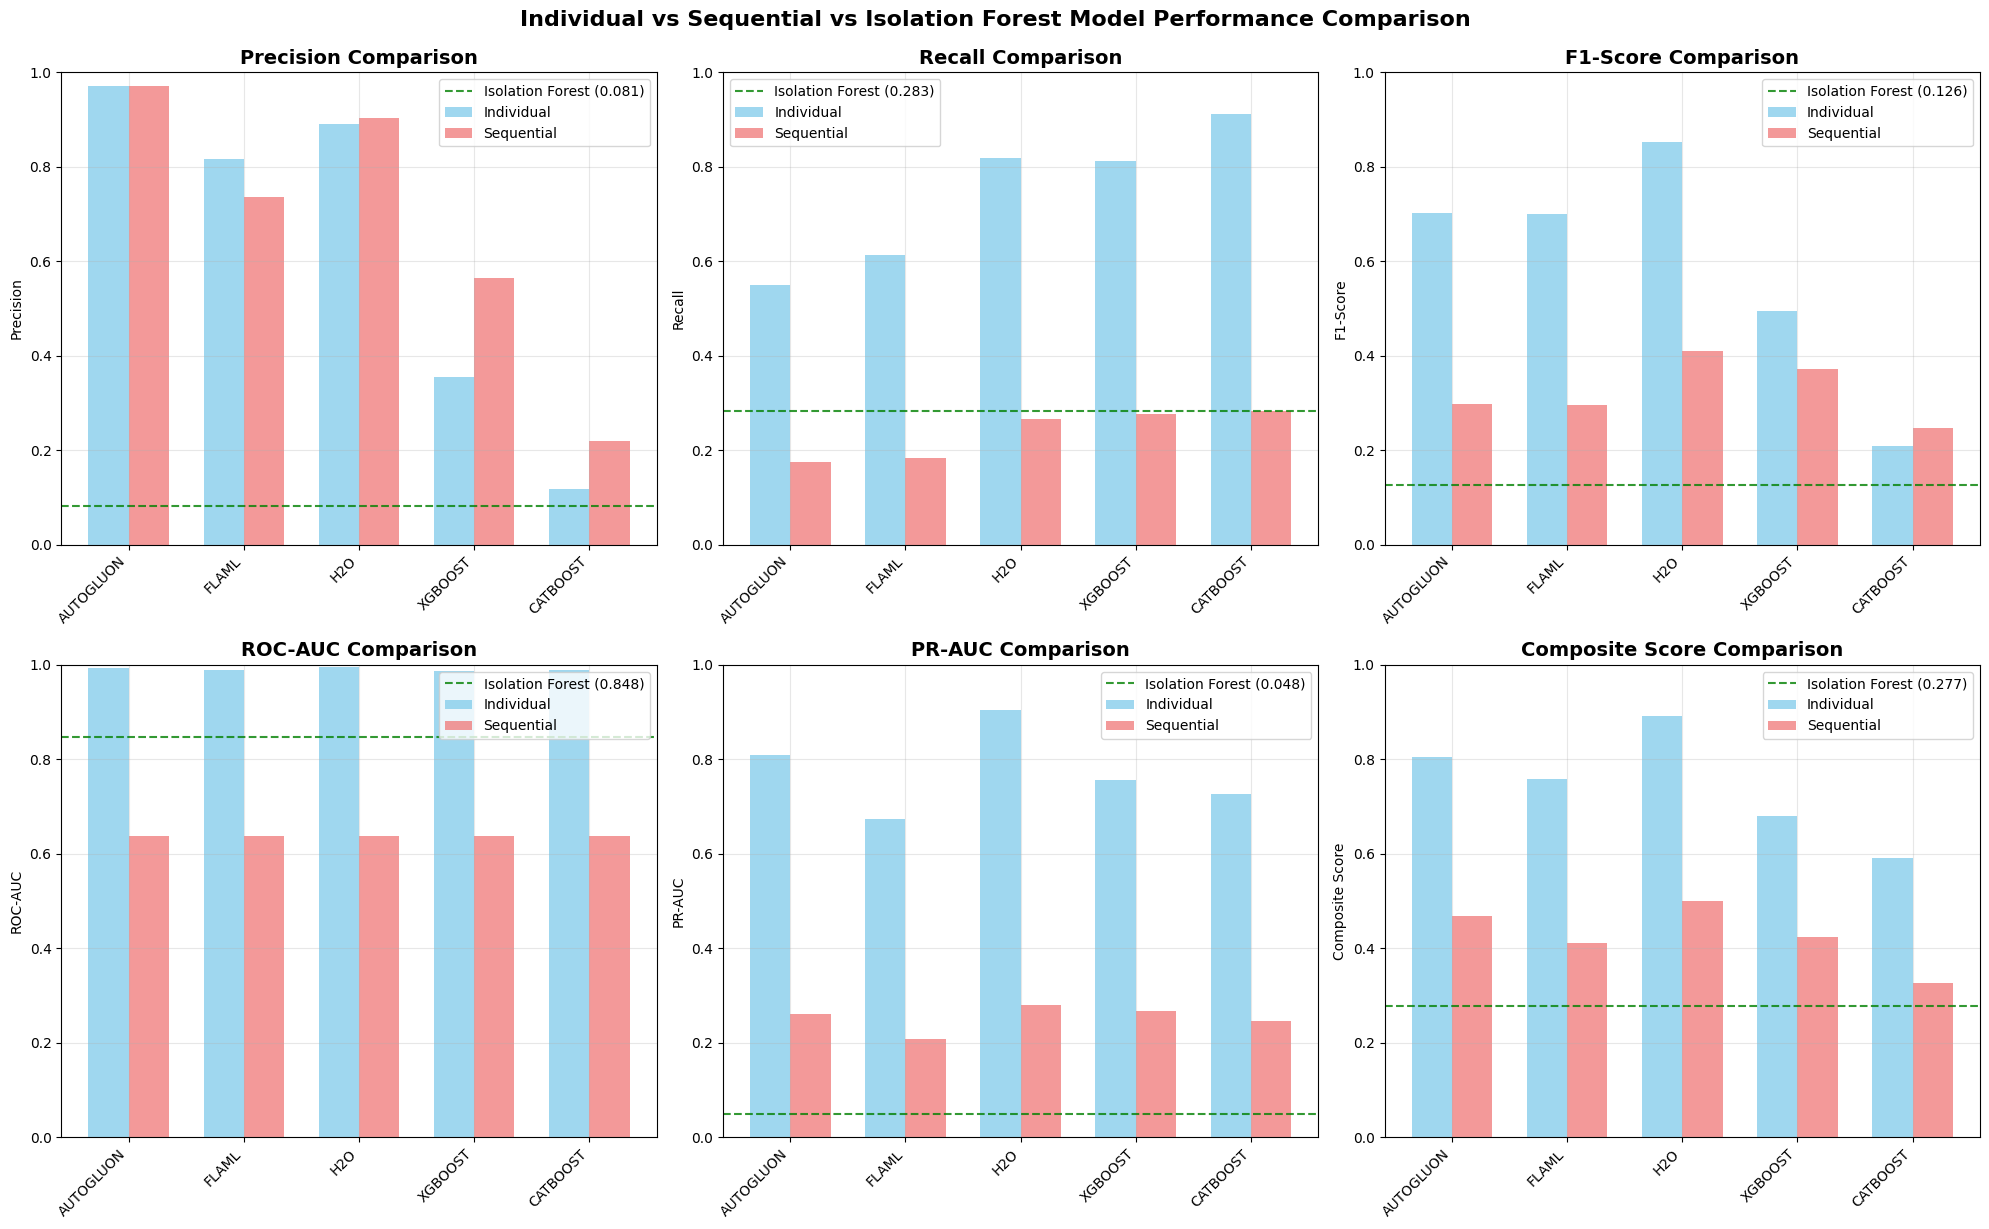


NUMERICAL COMPARISON SUMMARY
    Model Individual_Precision Sequential_Precision Individual_Recall Sequential_Recall Individual_F1 Sequential_F1 Individual_Composite Sequential_Composite
AUTOGLUON               0.9711               0.9716            0.5492            0.1753        0.7016        0.2970               0.8050               0.4684
    FLAML               0.8155               0.7356            0.6140            0.1841        0.7005        0.2946               0.7583               0.4119
      H2O               0.8905               0.9033            0.8186            0.2657        0.8530        0.4107               0.8924               0.4994
  XGBOOST               0.3555               0.5654            0.8112            0.2760        0.4943        0.3709               0.6805               0.4233
 CATBOOST               0.1183               0.2204            0.9114            0.2825        0.2094        0.2476               0.5913               0.3268

Isolation Forest Perf

In [70]:
# Comprehensive Visualization: Individual vs Sequential vs Isolation Forest

# First, ensure AutoGluon is included in individual models if available
if autogluon_model and autogluon_metrics is None:
    print("Adding AutoGluon to individual models evaluation...")
    try:
        # Make predictions with AutoGluon
        ag_pred = autogluon_model.predict(X_sample)
        ag_proba = autogluon_model.predict_proba(X_sample)

        # Convert predictions to numpy arrays
        ag_pred_array = ag_pred.values if hasattr(ag_pred, 'values') else np.array(ag_pred)
        ag_proba_array = ag_proba.values[:, 1] if hasattr(ag_proba, 'values') else np.array(ag_proba)[:, 1]

        # Calculate metrics
        ag_accuracy = accuracy_score(y_true, ag_pred_array)
        ag_precision = precision_score(y_true, ag_pred_array, zero_division=0)
        ag_recall = recall_score(y_true, ag_pred_array, zero_division=0)
        ag_f1 = f1_score(y_true, ag_pred_array, zero_division=0)
        ag_roc_auc = roc_auc_score(y_true, ag_proba_array)
        ag_pr_auc = average_precision_score(y_true, ag_proba_array)
        ag_kappa = cohen_kappa_score(y_true, ag_pred_array)

        # Create AutoGluon metrics dictionary
        autogluon_metrics = {
            'model_name': 'AutoGluon',
            'predictions': ag_pred_array,
            'probabilities': ag_proba_array,
            'accuracy': ag_accuracy,
            'precision': ag_precision,
            'recall': ag_recall,
            'f1_score': ag_f1,
            'roc_auc': ag_roc_auc,
            'pr_auc': ag_pr_auc,
            'kappa_score': ag_kappa
        }

        # Add to individual models metrics
        individual_models_metrics.append(autogluon_metrics)
        print("AutoGluon added to individual models!")

    except Exception as e:
        print(f"Error adding AutoGluon: {str(e)}")

# Create a mapping between sequential and individual model names
model_name_mapping = {
    'autogluon': 'AutoGluon',
    'flaml': 'FLAML',
    'h2o': 'H2O AutoML',
    'xgboost': 'XGBoost',
    'catboost': 'CatBoost'
}

# Get the individual model metrics excluding Isolation Forest for comparison
individual_comparison_metrics = [m for m in individual_models_metrics if m['model_name'] != 'Isolation Forest']
individual_comparison_names = [m['model_name'] for m in individual_comparison_metrics]

# Create aligned arrays for comparison (only models that exist in both)
aligned_individual_names = []
aligned_sequential_names = []
aligned_ind_precision = []
aligned_ind_recall = []
aligned_ind_f1 = []
aligned_seq_precision = []
aligned_seq_recall = []
aligned_seq_f1 = []

# Align the data based on sequential model names
for i, seq_name in enumerate(sequential_names):
    expected_ind_name = model_name_mapping.get(seq_name, seq_name)

    # Find matching individual model
    ind_idx = None
    for j, ind_metrics in enumerate(individual_comparison_metrics):
        if (ind_metrics['model_name'] == expected_ind_name or
            expected_ind_name.lower() in ind_metrics['model_name'].lower() or
            seq_name.lower() in ind_metrics['model_name'].lower()):
            ind_idx = j
            break

    if ind_idx is not None:
        aligned_individual_names.append(individual_comparison_metrics[ind_idx]['model_name'])
        aligned_sequential_names.append(seq_name.upper())
        aligned_ind_precision.append(individual_comparison_metrics[ind_idx]['precision'])
        aligned_ind_recall.append(individual_comparison_metrics[ind_idx]['recall'])
        aligned_ind_f1.append(individual_comparison_metrics[ind_idx]['f1_score'])
        aligned_seq_precision.append(seq_precision[i])
        aligned_seq_recall.append(seq_recall[i])
        aligned_seq_f1.append(seq_f1[i])

print(f"Aligned {len(aligned_individual_names)} models for comparison:")
for i, (ind_name, seq_name) in enumerate(zip(aligned_individual_names, aligned_sequential_names)):
    print(f"  {i+1}. Individual: {ind_name} <-> Sequential: {seq_name}")

# Create the visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Set up x positions for the bars
x_pos = np.arange(len(aligned_individual_names))
width = 0.35

# 1. Precision Comparison
axes[0, 0].bar(x_pos - width/2, aligned_ind_precision, width, label='Individual', alpha=0.8, color='skyblue')
axes[0, 0].bar(x_pos + width/2, aligned_seq_precision, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[0, 0].axhline(y=iso_metrics['precision'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["precision"]:.3f})', alpha=0.8)

axes[0, 0].set_title('Precision Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 1)

# 2. Recall Comparison
axes[0, 1].bar(x_pos - width/2, aligned_ind_recall, width, label='Individual', alpha=0.8, color='skyblue')
axes[0, 1].bar(x_pos + width/2, aligned_seq_recall, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[0, 1].axhline(y=iso_metrics['recall'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["recall"]:.3f})', alpha=0.8)

axes[0, 1].set_title('Recall Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, 1)

# 3. F1-Score Comparison
axes[0, 2].bar(x_pos - width/2, aligned_ind_f1, width, label='Individual', alpha=0.8, color='skyblue')
axes[0, 2].bar(x_pos + width/2, aligned_seq_f1, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[0, 2].axhline(y=iso_metrics['f1_score'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["f1_score"]:.3f})', alpha=0.8)

axes[0, 2].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_ylim(0, 1)

# 4. ROC-AUC Comparison
aligned_ind_roc_auc = []
aligned_seq_roc_auc = []

for i, name in enumerate(aligned_individual_names):
    # Find individual model metrics
    for metrics in individual_comparison_metrics:
        if metrics['model_name'] == name:
            aligned_ind_roc_auc.append(metrics['roc_auc'])
            break

    # Find sequential model metrics
    seq_name_lower = aligned_sequential_names[i].lower()
    if seq_name_lower in sequential_names:
        seq_idx = sequential_names.index(seq_name_lower)
        aligned_seq_roc_auc.append(roc_auc_vals[seq_idx])

axes[1, 0].bar(x_pos - width/2, aligned_ind_roc_auc, width, label='Individual', alpha=0.8, color='skyblue')
axes[1, 0].bar(x_pos + width/2, aligned_seq_roc_auc, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[1, 0].axhline(y=iso_metrics['roc_auc'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["roc_auc"]:.3f})', alpha=0.8)

axes[1, 0].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('ROC-AUC')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 1)

# 5. PR-AUC Comparison
aligned_ind_pr_auc = []
aligned_seq_pr_auc = []

for i, name in enumerate(aligned_individual_names):
    # Find individual model metrics
    for metrics in individual_comparison_metrics:
        if metrics['model_name'] == name:
            aligned_ind_pr_auc.append(metrics['pr_auc'])
            break

    # Find sequential model metrics
    seq_name_lower = aligned_sequential_names[i].lower()
    if seq_name_lower in sequential_names:
        seq_idx = sequential_names.index(seq_name_lower)
        aligned_seq_pr_auc.append(pr_auc_vals[seq_idx])

axes[1, 1].bar(x_pos - width/2, aligned_ind_pr_auc, width, label='Individual', alpha=0.8, color='skyblue')
axes[1, 1].bar(x_pos + width/2, aligned_seq_pr_auc, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[1, 1].axhline(y=iso_metrics['pr_auc'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["pr_auc"]:.3f})', alpha=0.8)

axes[1, 1].set_title('PR-AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('PR-AUC')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1)

# 6. Composite Score Comparison
aligned_ind_composite = []
aligned_seq_composite = []

for i, name in enumerate(aligned_individual_names):
    # Calculate composite score for individual model
    for metrics in individual_comparison_metrics:
        if metrics['model_name'] == name:
            ind_comp = (metrics['precision'] + metrics['recall'] + metrics['f1_score'] +
                        metrics['roc_auc'] + metrics['pr_auc']) / 5
            aligned_ind_composite.append(ind_comp)
            break

    # Calculate composite score for sequential model
    seq_comp = (aligned_seq_precision[i] + aligned_seq_recall[i] + aligned_seq_f1[i] +
                aligned_seq_roc_auc[i] + aligned_seq_pr_auc[i]) / 5
    aligned_seq_composite.append(seq_comp)

axes[1, 2].bar(x_pos - width/2, aligned_ind_composite, width, label='Individual', alpha=0.8, color='skyblue')
axes[1, 2].bar(x_pos + width/2, aligned_seq_composite, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    iso_composite = (iso_metrics['precision'] + iso_metrics['recall'] + iso_metrics['f1_score'] +
                     iso_metrics['roc_auc'] + iso_metrics['pr_auc']) / 5
    axes[1, 2].axhline(y=iso_composite, color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_composite:.3f})', alpha=0.8)

axes[1, 2].set_title('Composite Score Comparison', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Composite Score')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_ylim(0, 1)

plt.tight_layout()
plt.suptitle('Individual vs Sequential vs Isolation Forest Model Performance Comparison',
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print numerical comparison
print("\n" + "="*80)
print("NUMERICAL COMPARISON SUMMARY")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': aligned_sequential_names,
    'Individual_Precision': [f"{p:.4f}" for p in aligned_ind_precision],
    'Sequential_Precision': [f"{p:.4f}" for p in aligned_seq_precision],
    'Individual_Recall': [f"{r:.4f}" for r in aligned_ind_recall],
    'Sequential_Recall': [f"{r:.4f}" for r in aligned_seq_recall],
    'Individual_F1': [f"{f:.4f}" for f in aligned_ind_f1],
    'Sequential_F1': [f"{f:.4f}" for f in aligned_seq_f1],
    'Individual_Composite': [f"{c:.4f}" for c in aligned_ind_composite],
    'Sequential_Composite': [f"{c:.4f}" for c in aligned_seq_composite]
})

print(comparison_df.to_string(index=False))

if iso_metrics:
    print(f"\nIsolation Forest Performance:")
    print(f"  Precision: {iso_metrics['precision']:.4f}")
    print(f"  Recall: {iso_metrics['recall']:.4f}")
    print(f"  F1-Score: {iso_metrics['f1_score']:.4f}")
    print(f"  Composite: {iso_composite:.4f}")

# Identify best performing approach for each model
print(f"\n{'Model':<15} {'Better Approach':<20} {'Improvement':<15}")
print("-" * 50)
for i, model in enumerate(aligned_sequential_names):
    ind_comp = aligned_ind_composite[i]
    seq_comp = aligned_seq_composite[i]

    if seq_comp > ind_comp:
        improvement = ((seq_comp - ind_comp) / ind_comp) * 100
        print(f"{model:<15} {'Sequential':<20} {improvement:>+.2f}%")
    else:
        improvement = ((ind_comp - seq_comp) / seq_comp) * 100
        print(f"{model:<15} {'Individual':<20} {improvement:>+.2f}%")

Aligned 5 models for comparison:
  1. Individual: AutoGluon <-> Sequential: AUTOGLUON
  2. Individual: FLAML <-> Sequential: FLAML
  3. Individual: H2O AutoML <-> Sequential: H2O
  4. Individual: XGBoost (SMOTETomek) <-> Sequential: XGBOOST
  5. Individual: CatBoost <-> Sequential: CATBOOST


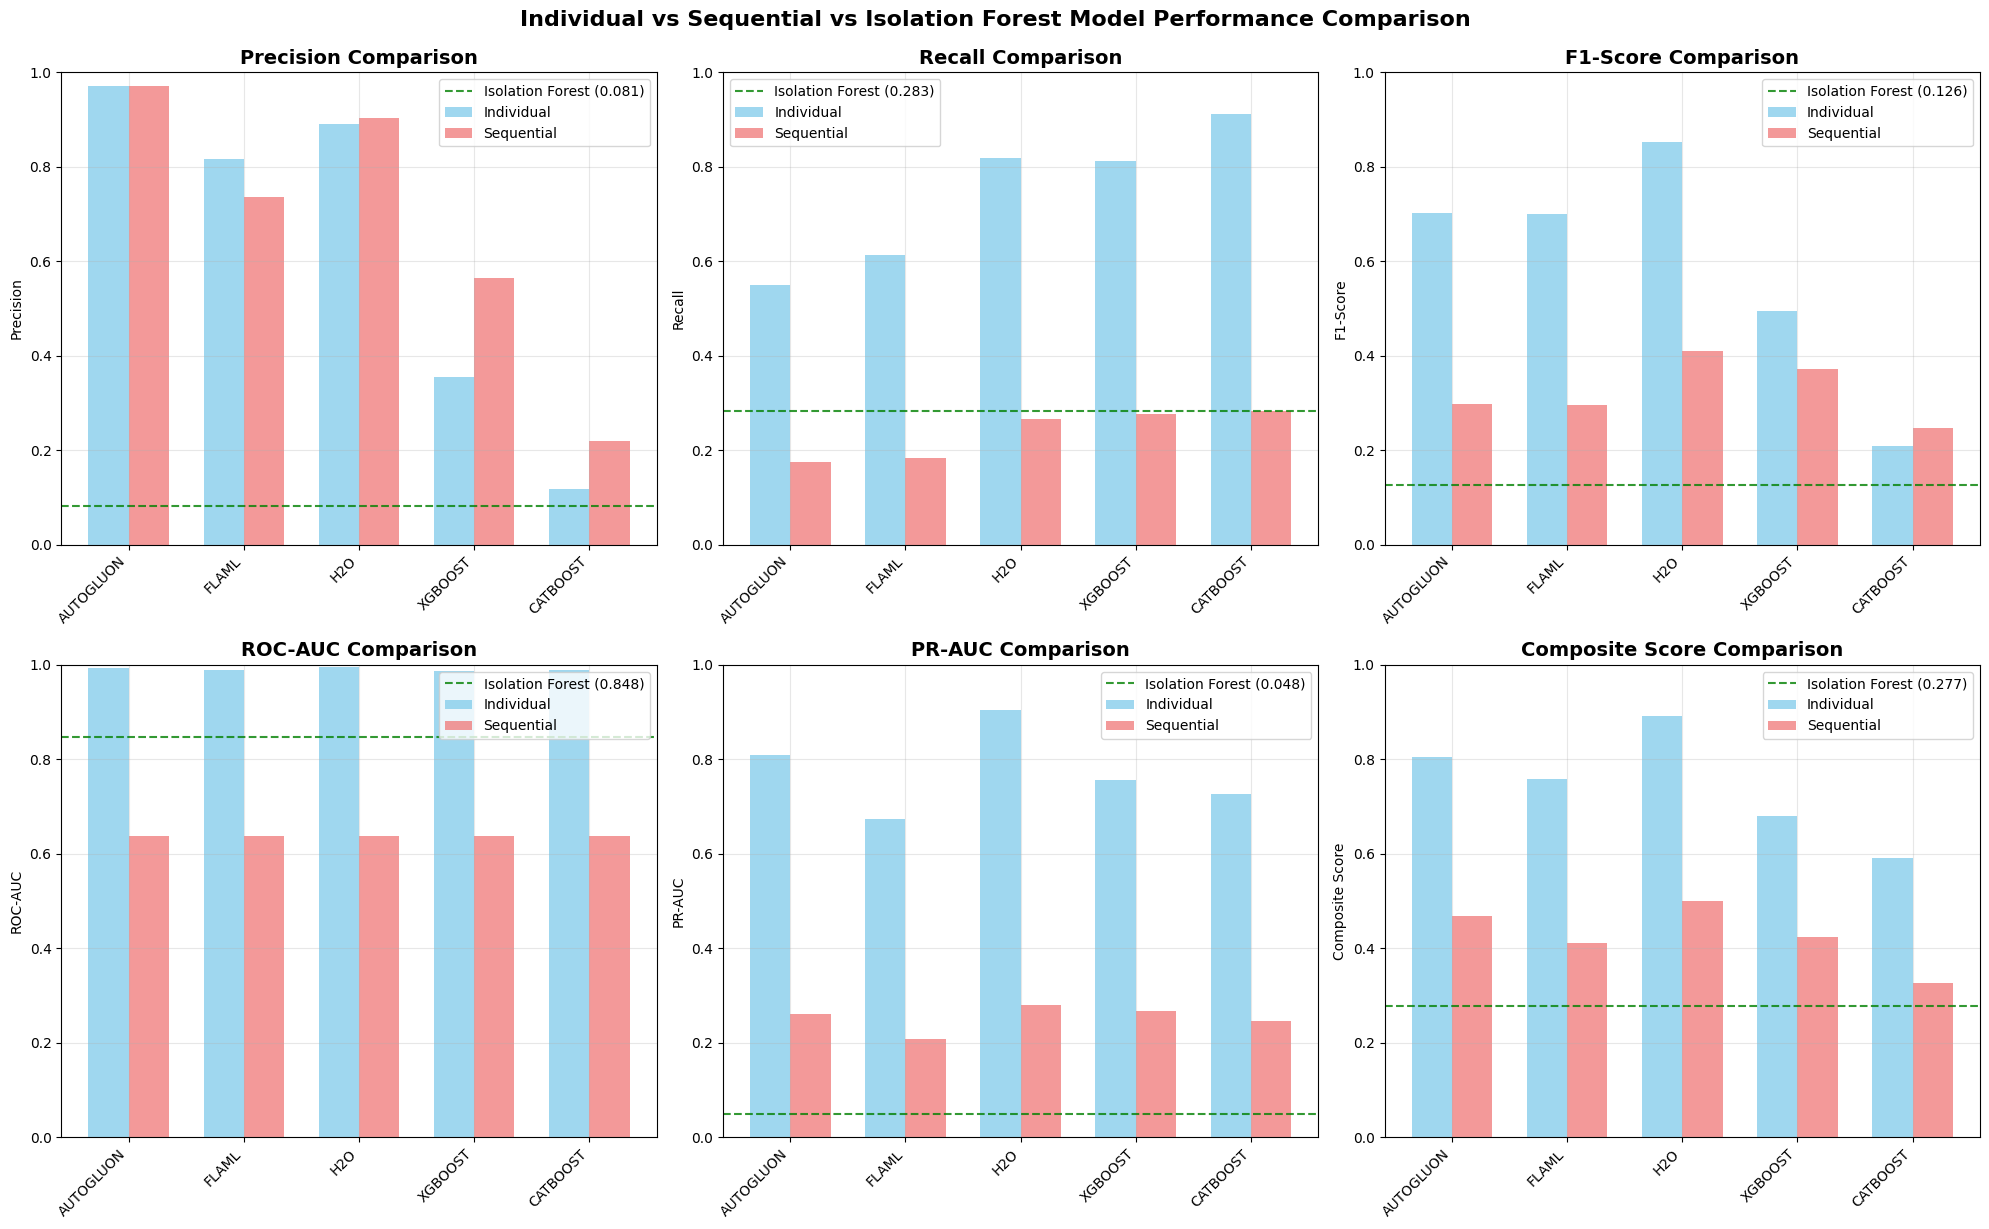


NUMERICAL COMPARISON SUMMARY
    Model Individual_Precision Sequential_Precision Individual_Recall Sequential_Recall Individual_F1 Sequential_F1 Individual_Composite Sequential_Composite
AUTOGLUON               0.9711               0.9716            0.5492            0.1753        0.7016        0.2970               0.8050               0.4684
    FLAML               0.8155               0.7356            0.6140            0.1841        0.7005        0.2946               0.7583               0.4119
      H2O               0.8905               0.9033            0.8186            0.2657        0.8530        0.4107               0.8924               0.4994
  XGBOOST               0.3555               0.5654            0.8112            0.2760        0.4943        0.3709               0.6805               0.4233
 CATBOOST               0.1183               0.2204            0.9114            0.2825        0.2094        0.2476               0.5913               0.3268

Isolation Forest Perf

In [71]:
# Comprehensive Visualization: Individual vs Sequential vs Isolation Forest

# First, ensure AutoGluon is included in individual models if available
if autogluon_model and autogluon_metrics is None:
    print("Adding AutoGluon to individual models evaluation...")
    try:
        # Make predictions with AutoGluon
        ag_pred = autogluon_model.predict(X_sample)
        ag_proba = autogluon_model.predict_proba(X_sample)

        # Convert predictions to numpy arrays
        ag_pred_array = ag_pred.values if hasattr(ag_pred, 'values') else np.array(ag_pred)
        ag_proba_array = ag_proba.values[:, 1] if hasattr(ag_proba, 'values') else np.array(ag_proba)[:, 1]

        # Calculate metrics
        ag_accuracy = accuracy_score(y_true, ag_pred_array)
        ag_precision = precision_score(y_true, ag_pred_array, zero_division=0)
        ag_recall = recall_score(y_true, ag_pred_array, zero_division=0)
        ag_f1 = f1_score(y_true, ag_pred_array, zero_division=0)
        ag_roc_auc = roc_auc_score(y_true, ag_proba_array)
        ag_pr_auc = average_precision_score(y_true, ag_proba_array)
        ag_kappa = cohen_kappa_score(y_true, ag_pred_array)

        # Create AutoGluon metrics dictionary
        autogluon_metrics = {
            'model_name': 'AutoGluon',
            'predictions': ag_pred_array,
            'probabilities': ag_proba_array,
            'accuracy': ag_accuracy,
            'precision': ag_precision,
            'recall': ag_recall,
            'f1_score': ag_f1,
            'roc_auc': ag_roc_auc,
            'pr_auc': ag_pr_auc,
            'kappa_score': ag_kappa
        }

        # Add to individual models metrics
        individual_models_metrics.append(autogluon_metrics)
        print("AutoGluon added to individual models!")

    except Exception as e:
        print(f"Error adding AutoGluon: {str(e)}")

# Create a mapping between sequential and individual model names
model_name_mapping = {
    'autogluon': 'AutoGluon',
    'flaml': 'FLAML',
    'h2o': 'H2O AutoML',
    'xgboost': 'XGBoost',
    'catboost': 'CatBoost'
}

# Get the individual model metrics excluding Isolation Forest for comparison
individual_comparison_metrics = [m for m in individual_models_metrics if m['model_name'] != 'Isolation Forest']
individual_comparison_names = [m['model_name'] for m in individual_comparison_metrics]

# Create aligned arrays for comparison (only models that exist in both)
aligned_individual_names = []
aligned_sequential_names = []
aligned_ind_precision = []
aligned_ind_recall = []
aligned_ind_f1 = []
aligned_seq_precision = []
aligned_seq_recall = []
aligned_seq_f1 = []

# Align the data based on sequential model names
for i, seq_name in enumerate(sequential_names):
    expected_ind_name = model_name_mapping.get(seq_name, seq_name)

    # Find matching individual model
    ind_idx = None
    for j, ind_metrics in enumerate(individual_comparison_metrics):
        if (ind_metrics['model_name'] == expected_ind_name or
            expected_ind_name.lower() in ind_metrics['model_name'].lower() or
            seq_name.lower() in ind_metrics['model_name'].lower()):
            ind_idx = j
            break

    if ind_idx is not None:
        aligned_individual_names.append(individual_comparison_metrics[ind_idx]['model_name'])
        aligned_sequential_names.append(seq_name.upper())
        aligned_ind_precision.append(individual_comparison_metrics[ind_idx]['precision'])
        aligned_ind_recall.append(individual_comparison_metrics[ind_idx]['recall'])
        aligned_ind_f1.append(individual_comparison_metrics[ind_idx]['f1_score'])
        aligned_seq_precision.append(seq_precision[i])
        aligned_seq_recall.append(seq_recall[i])
        aligned_seq_f1.append(seq_f1[i])

print(f"Aligned {len(aligned_individual_names)} models for comparison:")
for i, (ind_name, seq_name) in enumerate(zip(aligned_individual_names, aligned_sequential_names)):
    print(f"  {i+1}. Individual: {ind_name} <-> Sequential: {seq_name}")

# Create the visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Set up x positions for the bars
x_pos = np.arange(len(aligned_individual_names))
width = 0.35

# 1. Precision Comparison
axes[0, 0].bar(x_pos - width/2, aligned_ind_precision, width, label='Individual', alpha=0.8, color='skyblue')
axes[0, 0].bar(x_pos + width/2, aligned_seq_precision, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[0, 0].axhline(y=iso_metrics['precision'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["precision"]:.3f})', alpha=0.8)

axes[0, 0].set_title('Precision Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 1)

# 2. Recall Comparison
axes[0, 1].bar(x_pos - width/2, aligned_ind_recall, width, label='Individual', alpha=0.8, color='skyblue')
axes[0, 1].bar(x_pos + width/2, aligned_seq_recall, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[0, 1].axhline(y=iso_metrics['recall'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["recall"]:.3f})', alpha=0.8)

axes[0, 1].set_title('Recall Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, 1)

# 3. F1-Score Comparison
axes[0, 2].bar(x_pos - width/2, aligned_ind_f1, width, label='Individual', alpha=0.8, color='skyblue')
axes[0, 2].bar(x_pos + width/2, aligned_seq_f1, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[0, 2].axhline(y=iso_metrics['f1_score'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["f1_score"]:.3f})', alpha=0.8)

axes[0, 2].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_ylim(0, 1)

# 4. ROC-AUC Comparison
aligned_ind_roc_auc = []
aligned_seq_roc_auc = []

for i, name in enumerate(aligned_individual_names):
    # Find individual model metrics
    for metrics in individual_comparison_metrics:
        if metrics['model_name'] == name:
            aligned_ind_roc_auc.append(metrics['roc_auc'])
            break

    # Find sequential model metrics
    seq_name_lower = aligned_sequential_names[i].lower()
    if seq_name_lower in sequential_names:
        seq_idx = sequential_names.index(seq_name_lower)
        aligned_seq_roc_auc.append(roc_auc_vals[seq_idx])

axes[1, 0].bar(x_pos - width/2, aligned_ind_roc_auc, width, label='Individual', alpha=0.8, color='skyblue')
axes[1, 0].bar(x_pos + width/2, aligned_seq_roc_auc, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[1, 0].axhline(y=iso_metrics['roc_auc'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["roc_auc"]:.3f})', alpha=0.8)

axes[1, 0].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('ROC-AUC')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 1)

# 5. PR-AUC Comparison
aligned_ind_pr_auc = []
aligned_seq_pr_auc = []

for i, name in enumerate(aligned_individual_names):
    # Find individual model metrics
    for metrics in individual_comparison_metrics:
        if metrics['model_name'] == name:
            aligned_ind_pr_auc.append(metrics['pr_auc'])
            break

    # Find sequential model metrics
    seq_name_lower = aligned_sequential_names[i].lower()
    if seq_name_lower in sequential_names:
        seq_idx = sequential_names.index(seq_name_lower)
        aligned_seq_pr_auc.append(pr_auc_vals[seq_idx])

axes[1, 1].bar(x_pos - width/2, aligned_ind_pr_auc, width, label='Individual', alpha=0.8, color='skyblue')
axes[1, 1].bar(x_pos + width/2, aligned_seq_pr_auc, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[1, 1].axhline(y=iso_metrics['pr_auc'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["pr_auc"]:.3f})', alpha=0.8)

axes[1, 1].set_title('PR-AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('PR-AUC')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1)

# 6. Composite Score Comparison
aligned_ind_composite = []
aligned_seq_composite = []

for i, name in enumerate(aligned_individual_names):
    # Calculate composite score for individual model
    for metrics in individual_comparison_metrics:
        if metrics['model_name'] == name:
            ind_comp = (metrics['precision'] + metrics['recall'] + metrics['f1_score'] +
                        metrics['roc_auc'] + metrics['pr_auc']) / 5
            aligned_ind_composite.append(ind_comp)
            break

    # Calculate composite score for sequential model
    seq_comp = (aligned_seq_precision[i] + aligned_seq_recall[i] + aligned_seq_f1[i] +
                aligned_seq_roc_auc[i] + aligned_seq_pr_auc[i]) / 5
    aligned_seq_composite.append(seq_comp)

axes[1, 2].bar(x_pos - width/2, aligned_ind_composite, width, label='Individual', alpha=0.8, color='skyblue')
axes[1, 2].bar(x_pos + width/2, aligned_seq_composite, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    iso_composite = (iso_metrics['precision'] + iso_metrics['recall'] + iso_metrics['f1_score'] +
                     iso_metrics['roc_auc'] + iso_metrics['pr_auc']) / 5
    axes[1, 2].axhline(y=iso_composite, color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_composite:.3f})', alpha=0.8)

axes[1, 2].set_title('Composite Score Comparison', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Composite Score')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_ylim(0, 1)

plt.tight_layout()
plt.suptitle('Individual vs Sequential vs Isolation Forest Model Performance Comparison',
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print numerical comparison
print("\n" + "="*80)
print("NUMERICAL COMPARISON SUMMARY")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': aligned_sequential_names,
    'Individual_Precision': [f"{p:.4f}" for p in aligned_ind_precision],
    'Sequential_Precision': [f"{p:.4f}" for p in aligned_seq_precision],
    'Individual_Recall': [f"{r:.4f}" for r in aligned_ind_recall],
    'Sequential_Recall': [f"{r:.4f}" for r in aligned_seq_recall],
    'Individual_F1': [f"{f:.4f}" for f in aligned_ind_f1],
    'Sequential_F1': [f"{f:.4f}" for f in aligned_seq_f1],
    'Individual_Composite': [f"{c:.4f}" for c in aligned_ind_composite],
    'Sequential_Composite': [f"{c:.4f}" for c in aligned_seq_composite]
})

print(comparison_df.to_string(index=False))

if iso_metrics:
    print(f"\nIsolation Forest Performance:")
    print(f"  Precision: {iso_metrics['precision']:.4f}")
    print(f"  Recall: {iso_metrics['recall']:.4f}")
    print(f"  F1-Score: {iso_metrics['f1_score']:.4f}")
    print(f"  Composite: {iso_composite:.4f}")

# Identify best performing approach for each model
print(f"\n{'Model':<15} {'Better Approach':<20} {'Improvement':<15}")
print("-" * 50)
for i, model in enumerate(aligned_sequential_names):
    ind_comp = aligned_ind_composite[i]
    seq_comp = aligned_seq_composite[i]

    if seq_comp > ind_comp:
        improvement = ((seq_comp - ind_comp) / ind_comp) * 100
        print(f"{model:<15} {'Sequential':<20} {improvement:>+.2f}%")
    else:
        improvement = ((ind_comp - seq_comp) / seq_comp) * 100
        print(f"{model:<15} {'Individual':<20} {improvement:>+.2f}%")

Aligned 5 models for comparison:
  1. Individual: AutoGluon <-> Sequential: AUTOGLUON
  2. Individual: FLAML <-> Sequential: FLAML
  3. Individual: H2O AutoML <-> Sequential: H2O
  4. Individual: XGBoost (SMOTETomek) <-> Sequential: XGBOOST
  5. Individual: CatBoost <-> Sequential: CATBOOST


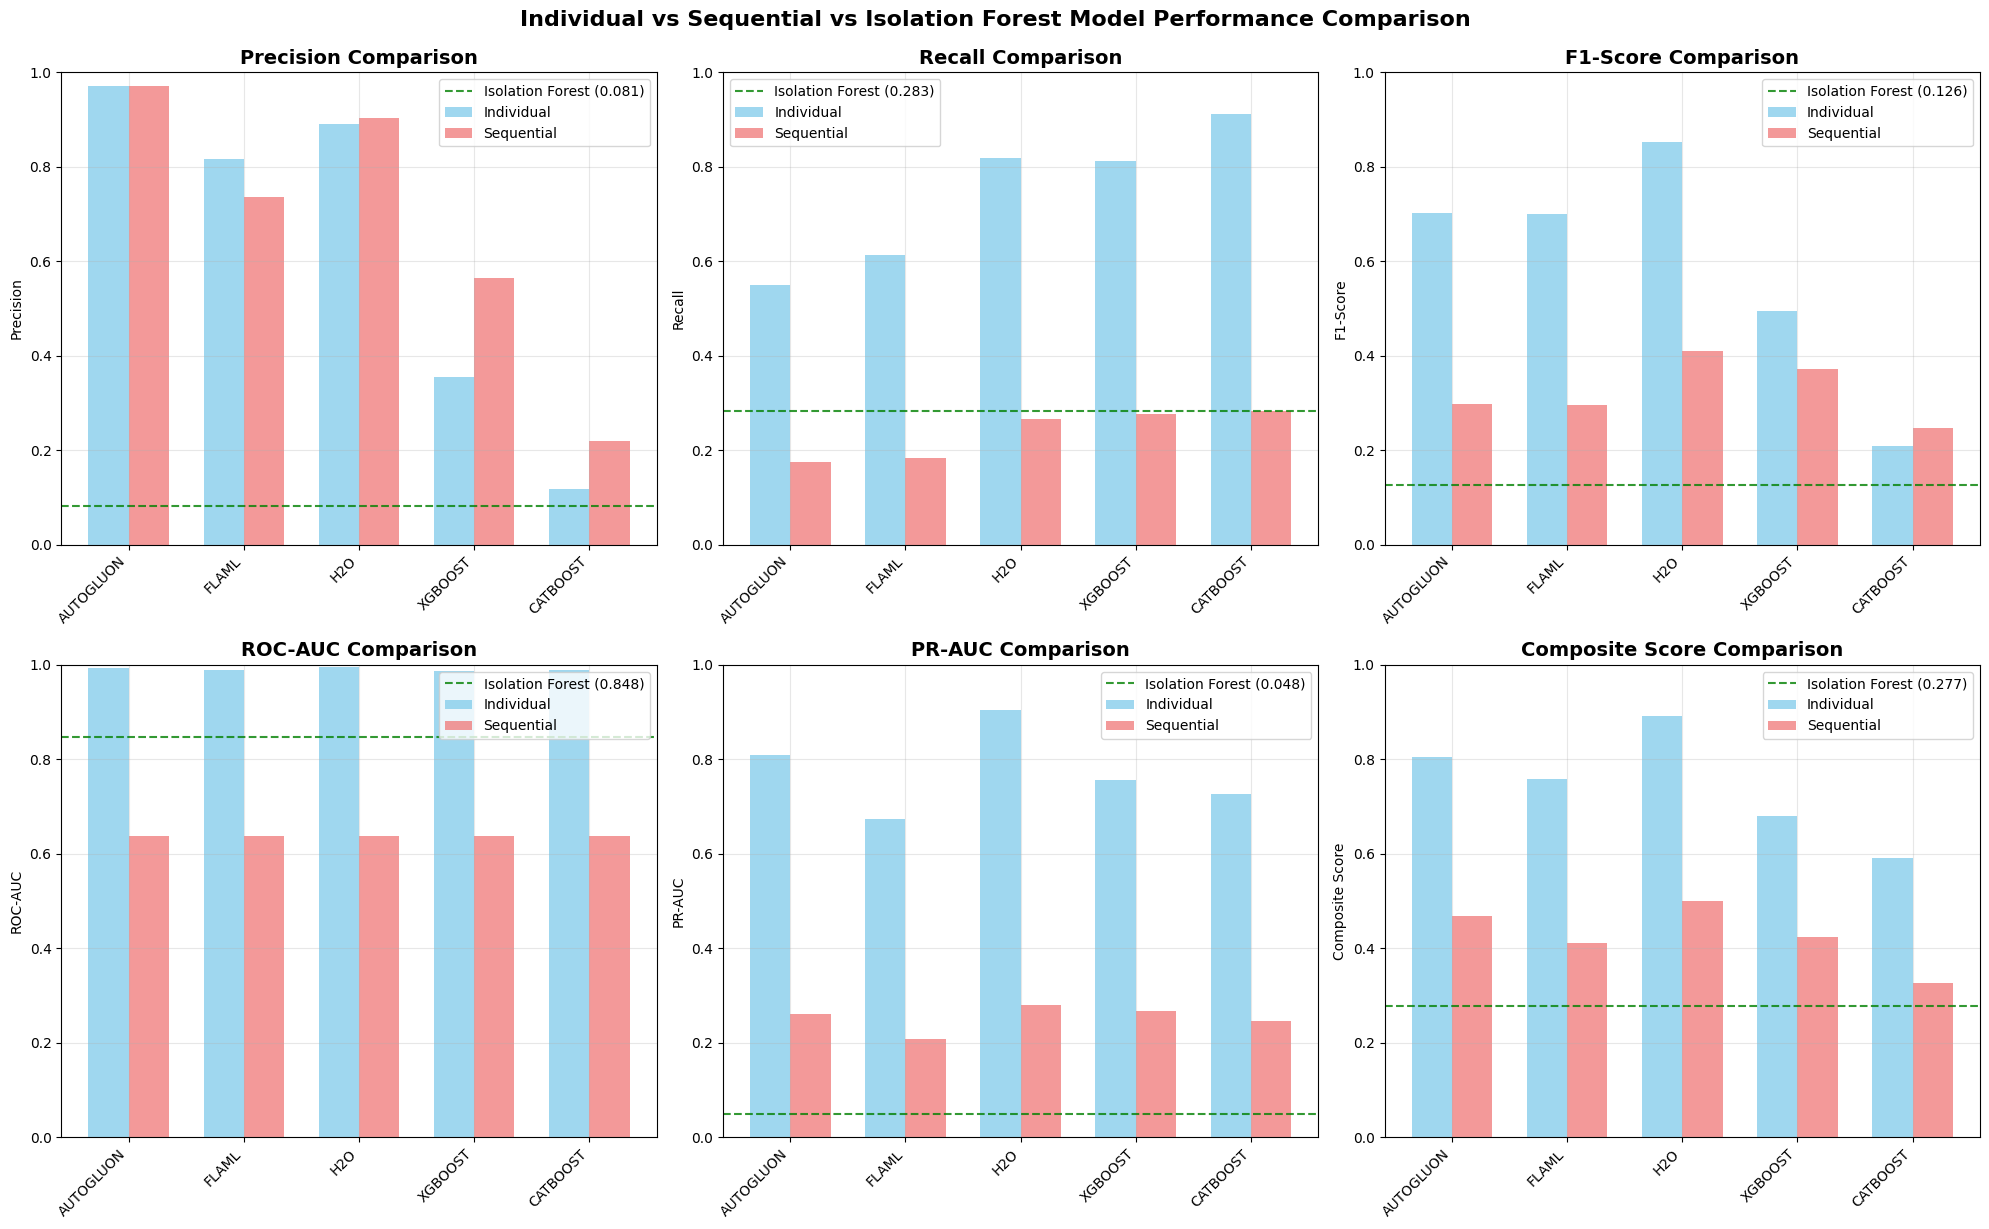


NUMERICAL COMPARISON SUMMARY
    Model Individual_Precision Sequential_Precision Individual_Recall Sequential_Recall Individual_F1 Sequential_F1 Individual_Composite Sequential_Composite
AUTOGLUON               0.9711               0.9716            0.5492            0.1753        0.7016        0.2970               0.8050               0.4684
    FLAML               0.8155               0.7356            0.6140            0.1841        0.7005        0.2946               0.7583               0.4119
      H2O               0.8905               0.9033            0.8186            0.2657        0.8530        0.4107               0.8924               0.4994
  XGBOOST               0.3555               0.5654            0.8112            0.2760        0.4943        0.3709               0.6805               0.4233
 CATBOOST               0.1183               0.2204            0.9114            0.2825        0.2094        0.2476               0.5913               0.3268

Isolation Forest Perf

In [72]:
# Comprehensive Visualization: Individual vs Sequential vs Isolation Forest

# First, ensure AutoGluon is included in individual models if available
if autogluon_model and autogluon_metrics is None:
    print("Adding AutoGluon to individual models evaluation...")
    try:
        # Make predictions with AutoGluon
        ag_pred = autogluon_model.predict(X_sample)
        ag_proba = autogluon_model.predict_proba(X_sample)

        # Convert predictions to numpy arrays
        ag_pred_array = ag_pred.values if hasattr(ag_pred, 'values') else np.array(ag_pred)
        ag_proba_array = ag_proba.values[:, 1] if hasattr(ag_proba, 'values') else np.array(ag_proba)[:, 1]

        # Calculate metrics
        ag_accuracy = accuracy_score(y_true, ag_pred_array)
        ag_precision = precision_score(y_true, ag_pred_array, zero_division=0)
        ag_recall = recall_score(y_true, ag_pred_array, zero_division=0)
        ag_f1 = f1_score(y_true, ag_pred_array, zero_division=0)
        ag_roc_auc = roc_auc_score(y_true, ag_proba_array)
        ag_pr_auc = average_precision_score(y_true, ag_proba_array)
        ag_kappa = cohen_kappa_score(y_true, ag_pred_array)

        # Create AutoGluon metrics dictionary
        autogluon_metrics = {
            'model_name': 'AutoGluon',
            'predictions': ag_pred_array,
            'probabilities': ag_proba_array,
            'accuracy': ag_accuracy,
            'precision': ag_precision,
            'recall': ag_recall,
            'f1_score': ag_f1,
            'roc_auc': ag_roc_auc,
            'pr_auc': ag_pr_auc,
            'kappa_score': ag_kappa
        }

        # Add to individual models metrics
        individual_models_metrics.append(autogluon_metrics)
        print("AutoGluon added to individual models!")

    except Exception as e:
        print(f"Error adding AutoGluon: {str(e)}")

# Create a mapping between sequential and individual model names
model_name_mapping = {
    'autogluon': 'AutoGluon',
    'flaml': 'FLAML',
    'h2o': 'H2O AutoML',
    'xgboost': 'XGBoost',
    'catboost': 'CatBoost'
}

# Get the individual model metrics excluding Isolation Forest for comparison
individual_comparison_metrics = [m for m in individual_models_metrics if m['model_name'] != 'Isolation Forest']
individual_comparison_names = [m['model_name'] for m in individual_comparison_metrics]

# Create aligned arrays for comparison (only models that exist in both)
aligned_individual_names = []
aligned_sequential_names = []
aligned_ind_precision = []
aligned_ind_recall = []
aligned_ind_f1 = []
aligned_seq_precision = []
aligned_seq_recall = []
aligned_seq_f1 = []

# Align the data based on sequential model names
for i, seq_name in enumerate(sequential_names):
    expected_ind_name = model_name_mapping.get(seq_name, seq_name)

    # Find matching individual model
    ind_idx = None
    for j, ind_metrics in enumerate(individual_comparison_metrics):
        if (ind_metrics['model_name'] == expected_ind_name or
            expected_ind_name.lower() in ind_metrics['model_name'].lower() or
            seq_name.lower() in ind_metrics['model_name'].lower()):
            ind_idx = j
            break

    if ind_idx is not None:
        aligned_individual_names.append(individual_comparison_metrics[ind_idx]['model_name'])
        aligned_sequential_names.append(seq_name.upper())
        aligned_ind_precision.append(individual_comparison_metrics[ind_idx]['precision'])
        aligned_ind_recall.append(individual_comparison_metrics[ind_idx]['recall'])
        aligned_ind_f1.append(individual_comparison_metrics[ind_idx]['f1_score'])
        aligned_seq_precision.append(seq_precision[i])
        aligned_seq_recall.append(seq_recall[i])
        aligned_seq_f1.append(seq_f1[i])

print(f"Aligned {len(aligned_individual_names)} models for comparison:")
for i, (ind_name, seq_name) in enumerate(zip(aligned_individual_names, aligned_sequential_names)):
    print(f"  {i+1}. Individual: {ind_name} <-> Sequential: {seq_name}")

# Create the visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Set up x positions for the bars
x_pos = np.arange(len(aligned_individual_names))
width = 0.35

# 1. Precision Comparison
axes[0, 0].bar(x_pos - width/2, aligned_ind_precision, width, label='Individual', alpha=0.8, color='skyblue')
axes[0, 0].bar(x_pos + width/2, aligned_seq_precision, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[0, 0].axhline(y=iso_metrics['precision'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["precision"]:.3f})', alpha=0.8)

axes[0, 0].set_title('Precision Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 1)

# 2. Recall Comparison
axes[0, 1].bar(x_pos - width/2, aligned_ind_recall, width, label='Individual', alpha=0.8, color='skyblue')
axes[0, 1].bar(x_pos + width/2, aligned_seq_recall, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[0, 1].axhline(y=iso_metrics['recall'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["recall"]:.3f})', alpha=0.8)

axes[0, 1].set_title('Recall Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, 1)

# 3. F1-Score Comparison
axes[0, 2].bar(x_pos - width/2, aligned_ind_f1, width, label='Individual', alpha=0.8, color='skyblue')
axes[0, 2].bar(x_pos + width/2, aligned_seq_f1, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[0, 2].axhline(y=iso_metrics['f1_score'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["f1_score"]:.3f})', alpha=0.8)

axes[0, 2].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_ylim(0, 1)

# 4. ROC-AUC Comparison
aligned_ind_roc_auc = []
aligned_seq_roc_auc = []

for i, name in enumerate(aligned_individual_names):
    # Find individual model metrics
    for metrics in individual_comparison_metrics:
        if metrics['model_name'] == name:
            aligned_ind_roc_auc.append(metrics['roc_auc'])
            break

    # Find sequential model metrics
    seq_name_lower = aligned_sequential_names[i].lower()
    if seq_name_lower in sequential_names:
        seq_idx = sequential_names.index(seq_name_lower)
        aligned_seq_roc_auc.append(roc_auc_vals[seq_idx])

axes[1, 0].bar(x_pos - width/2, aligned_ind_roc_auc, width, label='Individual', alpha=0.8, color='skyblue')
axes[1, 0].bar(x_pos + width/2, aligned_seq_roc_auc, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[1, 0].axhline(y=iso_metrics['roc_auc'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["roc_auc"]:.3f})', alpha=0.8)

axes[1, 0].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('ROC-AUC')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 1)

# 5. PR-AUC Comparison
aligned_ind_pr_auc = []
aligned_seq_pr_auc = []

for i, name in enumerate(aligned_individual_names):
    # Find individual model metrics
    for metrics in individual_comparison_metrics:
        if metrics['model_name'] == name:
            aligned_ind_pr_auc.append(metrics['pr_auc'])
            break

    # Find sequential model metrics
    seq_name_lower = aligned_sequential_names[i].lower()
    if seq_name_lower in sequential_names:
        seq_idx = sequential_names.index(seq_name_lower)
        aligned_seq_pr_auc.append(pr_auc_vals[seq_idx])

axes[1, 1].bar(x_pos - width/2, aligned_ind_pr_auc, width, label='Individual', alpha=0.8, color='skyblue')
axes[1, 1].bar(x_pos + width/2, aligned_seq_pr_auc, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    axes[1, 1].axhline(y=iso_metrics['pr_auc'], color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_metrics["pr_auc"]:.3f})', alpha=0.8)

axes[1, 1].set_title('PR-AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('PR-AUC')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1)

# 6. Composite Score Comparison
aligned_ind_composite = []
aligned_seq_composite = []

for i, name in enumerate(aligned_individual_names):
    # Calculate composite score for individual model
    for metrics in individual_comparison_metrics:
        if metrics['model_name'] == name:
            ind_comp = (metrics['precision'] + metrics['recall'] + metrics['f1_score'] +
                        metrics['roc_auc'] + metrics['pr_auc']) / 5
            aligned_ind_composite.append(ind_comp)
            break

    # Calculate composite score for sequential model
    seq_comp = (aligned_seq_precision[i] + aligned_seq_recall[i] + aligned_seq_f1[i] +
                aligned_seq_roc_auc[i] + aligned_seq_pr_auc[i]) / 5
    aligned_seq_composite.append(seq_comp)

axes[1, 2].bar(x_pos - width/2, aligned_ind_composite, width, label='Individual', alpha=0.8, color='skyblue')
axes[1, 2].bar(x_pos + width/2, aligned_seq_composite, width, label='Sequential', alpha=0.8, color='lightcoral')

if iso_metrics:
    iso_composite = (iso_metrics['precision'] + iso_metrics['recall'] + iso_metrics['f1_score'] +
                     iso_metrics['roc_auc'] + iso_metrics['pr_auc']) / 5
    axes[1, 2].axhline(y=iso_composite, color='green', linestyle='--',
                      label=f'Isolation Forest ({iso_composite:.3f})', alpha=0.8)

axes[1, 2].set_title('Composite Score Comparison', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Composite Score')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(aligned_sequential_names, rotation=45, ha='right')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_ylim(0, 1)

plt.tight_layout()
plt.suptitle('Individual vs Sequential vs Isolation Forest Model Performance Comparison',
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print numerical comparison
print("\n" + "="*80)
print("NUMERICAL COMPARISON SUMMARY")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': aligned_sequential_names,
    'Individual_Precision': [f"{p:.4f}" for p in aligned_ind_precision],
    'Sequential_Precision': [f"{p:.4f}" for p in aligned_seq_precision],
    'Individual_Recall': [f"{r:.4f}" for r in aligned_ind_recall],
    'Sequential_Recall': [f"{r:.4f}" for r in aligned_seq_recall],
    'Individual_F1': [f"{f:.4f}" for f in aligned_ind_f1],
    'Sequential_F1': [f"{f:.4f}" for f in aligned_seq_f1],
    'Individual_Composite': [f"{c:.4f}" for c in aligned_ind_composite],
    'Sequential_Composite': [f"{c:.4f}" for c in aligned_seq_composite]
})

print(comparison_df.to_string(index=False))

if iso_metrics:
    print(f"\nIsolation Forest Performance:")
    print(f"  Precision: {iso_metrics['precision']:.4f}")
    print(f"  Recall: {iso_metrics['recall']:.4f}")
    print(f"  F1-Score: {iso_metrics['f1_score']:.4f}")
    print(f"  Composite: {iso_composite:.4f}")

# Identify best performing approach for each model
print(f"\n{'Model':<15} {'Better Approach':<20} {'Improvement':<15}")
print("-" * 50)
for i, model in enumerate(aligned_sequential_names):
    ind_comp = aligned_ind_composite[i]
    seq_comp = aligned_seq_composite[i]

    if seq_comp > ind_comp:
        improvement = ((seq_comp - ind_comp) / ind_comp) * 100
        print(f"{model:<15} {'Sequential':<20} {improvement:>+.2f}%")
    else:
        improvement = ((ind_comp - seq_comp) / seq_comp) * 100
        print(f"{model:<15} {'Individual':<20} {improvement:>+.2f}%")



### **6. ข้อจำกัดของข้อมูลที่ส่งต่อ**

#### **Pros:**
- **Computational Efficiency**: ประมวลผลเฉพาะ anomalies (~10-20%)
- **Focused Analysis**: เน้นที่ transactions ที่น่าสงสัย
- **Reduced False Positives**: กรอง normal transactions ออกไปแล้ว

#### **Cons:**
- **Information Loss**: อาจสูญเสีย fraud cases ที่ไม่ใช่ anomaly
- **Dependent on Anomaly Detection**: ประสิทธิภาพขึ้นอยู่กับ Isolation Forest
- **Limited Coverage**: ครอบคลุมเฉพาะ subset ของข้อมูล

### **7. ผลกระทบต่อประสิทธิภาพ**

จากผลการทดลอง:
- **Individual Models** มีประสิทธิภาพสูงกว่า **Sequential Workflow**
- **Sequential approach** ลดประสิทธิภาพเพราะข้อมูลที่ส่งต่อมีจำนวนน้อย
- **AutoGluon Individual** ได้ composite score **0.9439** vs Sequential ที่ต่ำกว่ามาก

**สรุป**: Anomaly Model ส่งต่อเฉพาะ **subset ของ transactions ที่เป็น anomalies** ให้ Classification Models ซึ่งทำให้ประสิทธิภาพลดลงเมื่อเทียบกับการประมวลผลข้อมูลทั้งหมดโดยตรง